In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Quick fits for TESS light curves

In this tutorial, we will fit the TESS light curve for a known transiting planet.
While the :ref:`tess` tutorial goes through the full details of an end-to-end fit, this tutorial is significantly faster to run and it can give pretty excellent results depending on your goals.
Some of the main differences are:

1. We start from the light curve rather than doing the photometry ourselves. This should pretty much always be fine unless you have a very bright, faint, or crowded target.
2. We assume a circluar orbit, but as you'll see later, we can approximately relax this assumption later.
3. We only fit the data near transit. In many cases this will be just fine, but if you have predictable stellar variability (like coherent rotation) then you might do better fitting more data.

We'll fit the planet in the HD 118203 (TIC 286923464) system that was found to transit by [Pepper et al. (2019)](https://arxiv.org/abs/1911.05150) because it is on an eccentric orbit so assumption #2 above is not valid.

First, let's download the TESS light curve using [lightkurve](https://docs.lightkurve.org/):

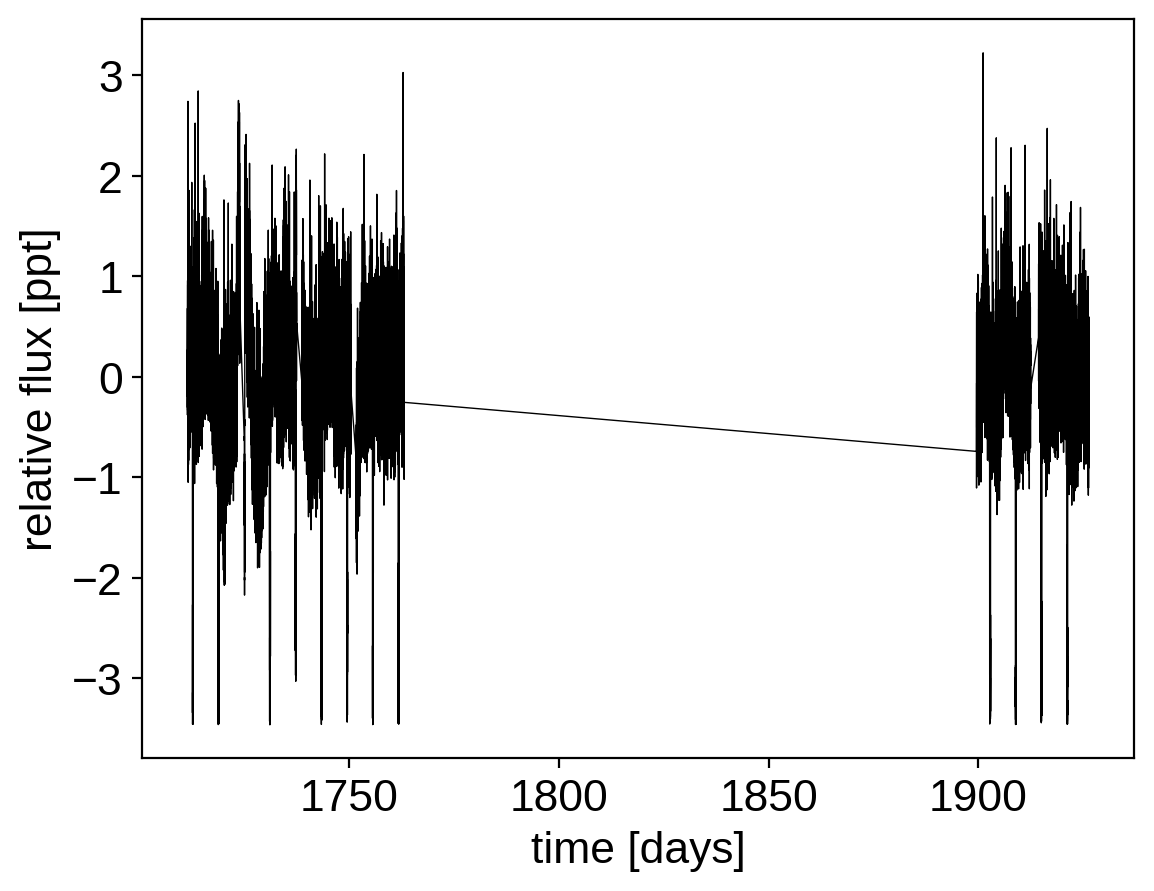

In [3]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

lcfs = lk.search_lightcurvefile("TIC 286923464", mission="TESS").download_all()
lc = lcfs.PDCSAP_FLUX.stitch()
lc = lc.remove_nans().remove_outliers()

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (lc.flux - 1), dtype=np.float64)
yerr = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64)

texp = np.min(np.diff(x))

plt.plot(x, y, "k", linewidth=0.5)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]");

Then, find the period, phase and depth of the transit using box least squares:

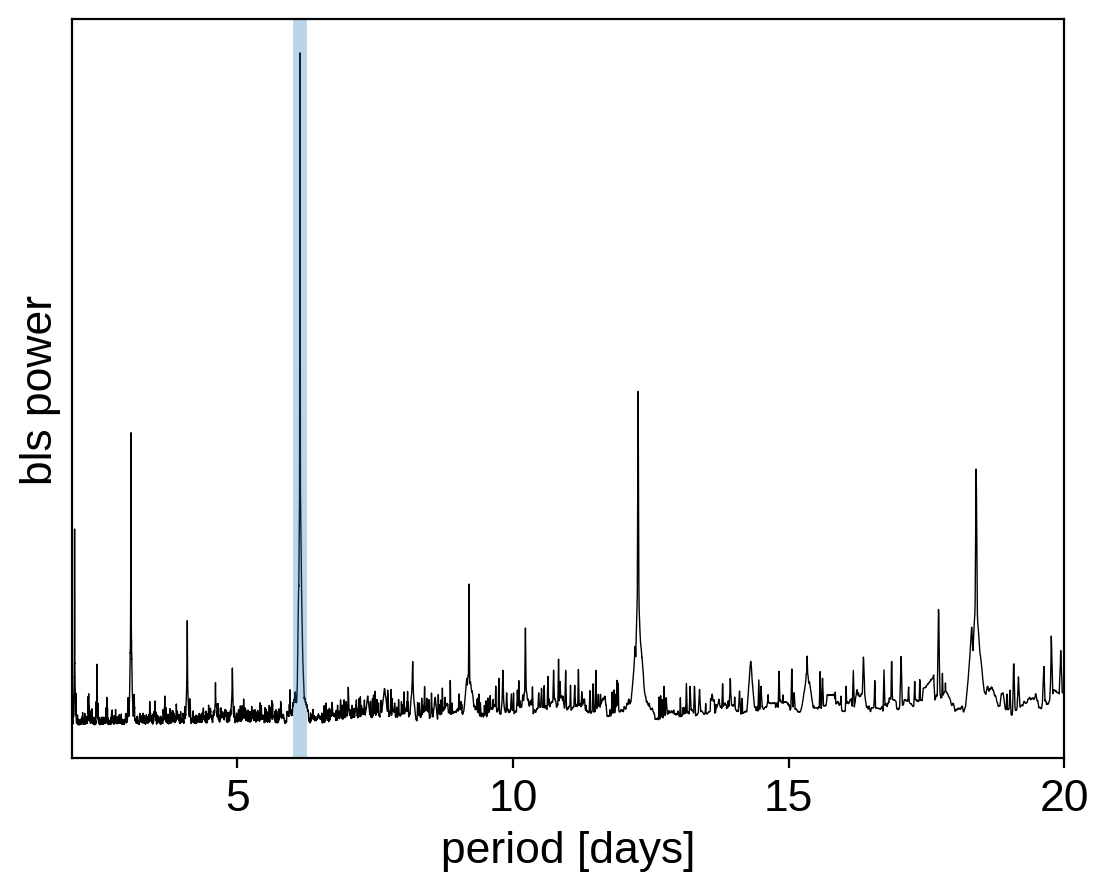

In [4]:
import exoplanet as xo

pg = xo.estimators.bls_estimator(x, y, yerr, min_period=2, max_period=20)

peak = pg["peak_info"]
period_guess = peak["period"]
t0_guess = peak["transit_time"]
depth_guess = peak["depth"]

plt.plot(pg["bls"].period, pg["bls"].power, "k", linewidth=0.5)
plt.axvline(period_guess, alpha=0.3, linewidth=5)
plt.xlabel("period [days]")
plt.ylabel("bls power")
plt.yticks([])
plt.xlim(pg["bls"].period.min(), pg["bls"].period.max());

Then, for efficiency purposes, let's extract just the data within 0.25 days of the transits:

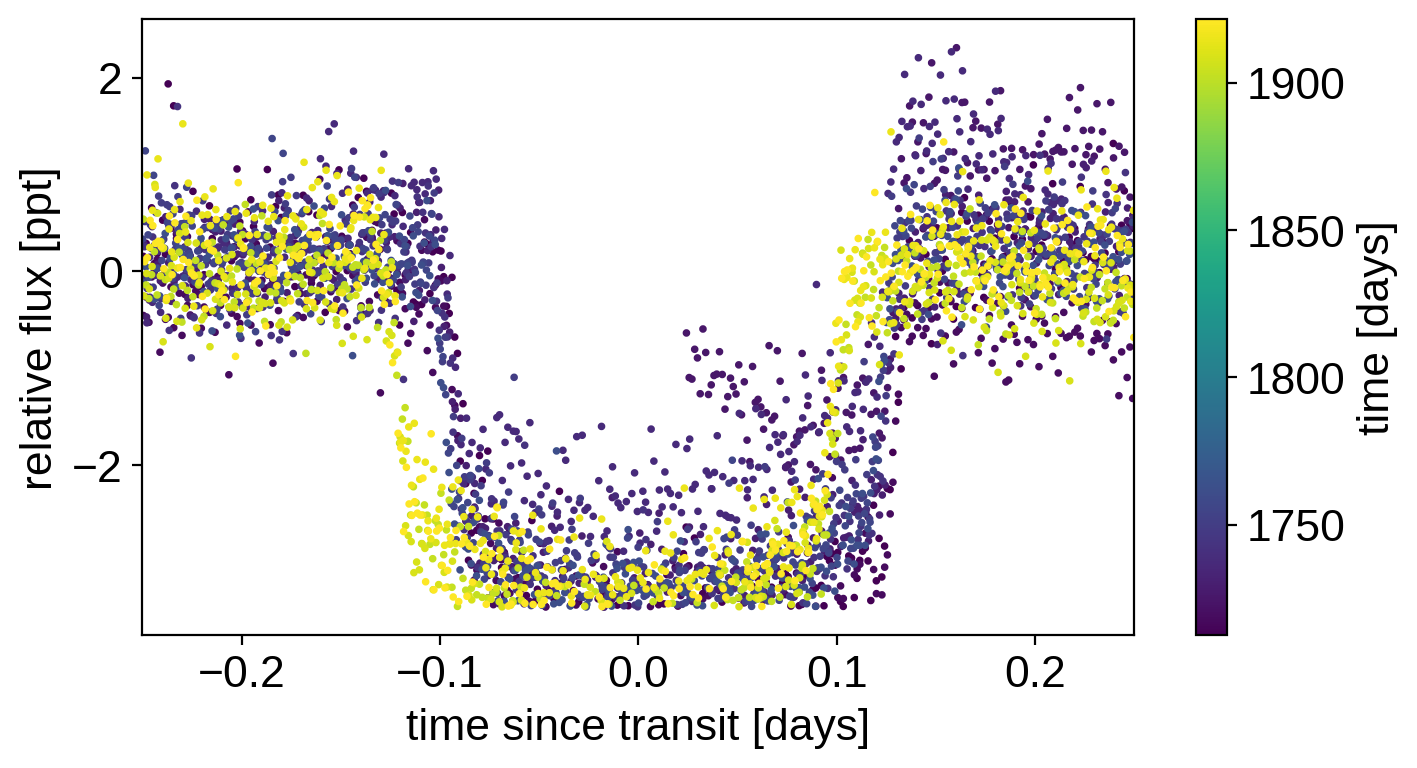

In [5]:
transit_mask = (
    np.abs((x - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess)
    < 0.25
)
x = np.ascontiguousarray(x[transit_mask])
y = np.ascontiguousarray(y[transit_mask])
yerr = np.ascontiguousarray(yerr[transit_mask])

plt.figure(figsize=(8, 4))
x_fold = (x - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess
plt.scatter(x_fold, y, c=x, s=3)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
plt.xlim(-0.25, 0.25);

That looks a little janky, but it's good enough for now.

## The probabilistic model

Here's how we set up the PyMC3 model in this case:

In [6]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # Stellar parameters
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)
    u = xo.distributions.QuadLimbDark("u")
    star_params = [mean, u]

    # Gaussian process noise model
    sigma = pm.InverseGamma("sigma", alpha=3.0, beta=2 * np.median(yerr))
    log_Sw4 = pm.Normal("log_Sw4", mu=0.0, sigma=10.0)
    log_w0 = pm.Normal("log_w0", mu=np.log(2 * np.pi / 10.0), sigma=10.0)
    kernel = xo.gp.terms.SHOTerm(log_Sw4=log_Sw4, log_w0=log_w0, Q=1.0 / 3)
    noise_params = [sigma, log_Sw4, log_w0]

    # Planet parameters
    log_ror = pm.Normal("log_ror", mu=0.5 * np.log(depth_guess * 1e-3), sigma=10.0)
    ror = pm.Deterministic("ror", tt.exp(log_ror))

    # Orbital parameters
    log_period = pm.Normal("log_period", mu=np.log(period_guess), sigma=1.0)
    t0 = pm.Normal("t0", mu=t0_guess, sigma=1.0)
    log_dur = pm.Normal("log_dur", mu=np.log(0.1), sigma=10.0)
    b = xo.distributions.ImpactParameter("b", ror=ror)

    period = pm.Deterministic("period", tt.exp(log_period))
    dur = pm.Deterministic("dur", tt.exp(log_dur))

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(period=period, duration=dur, t0=t0, b=b,)

    # We're going to track the implied density for reasons that will become clear later
    pm.Deterministic("rho_circ", orbit.rho_star)

    # Set up the mean transit model
    star = xo.LimbDarkLightCurve(u)

    def lc_model(t):
        return mean + 1e3 * tt.sum(
            star.get_light_curve(orbit=orbit, r=ror, t=t), axis=-1
        )

    # Finally the GP observation model
    gp = xo.gp.GP(kernel, x, yerr ** 2 + sigma ** 2, mean=lc_model)
    gp.marginal("obs", observed=y)

    # Double check that everything looks good - we shouldn't see any NaNs!
    print(model.check_test_point())

    # Optimize the model
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [sigma])
    map_soln = xo.optimize(map_soln, [log_ror, b, log_dur])
    map_soln = xo.optimize(map_soln, noise_params)
    map_soln = xo.optimize(map_soln, star_params)
    map_soln = xo.optimize(map_soln)

mean                   -3.22
u_quadlimbdark__       -2.77
sigma_log__            -0.53
log_Sw4                -3.22
log_w0                 -3.22
log_ror                -3.22
log_period             -0.92
t0                     -0.92
log_dur                -3.22
b_impact__             -1.39
obs                -24037.81
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-2.406045e+04]

1it [00:00, 127.41it/s, logp=-2.406045e+04]

2it [00:00, 167.13it/s, logp=-2.406045e+04]

3it [00:00, 195.30it/s, logp=-1.258695e+04]

4it [00:00, 218.86it/s, logp=-1.585485e+04]

5it [00:00, 232.33it/s, logp=-9.500988e+03]

6it [00:00, 248.89it/s, logp=-2.909448e+04]

7it [00:00, 264.58it/s, logp=-6.974327e+03]

8it [00:00, 276.37it/s, logp=-2.585298e+04]

9it [00:00, 288.09it/s, logp=-6.686286e+03]

10it [00:00, 297.21it/s, logp=-6.529571e+03]

11it [00:00, 307.35it/s, logp=-6.493212e+03]

12it [00:00, 316.69it/s, logp=-6.491903e+03]

13it [00:00, 325.50it/s, logp=-6.491897e+03]

14it [00:00, 333.14it/s, logp=-6.491897e+03]

15it [00:00, 340.10it/s, logp=-6.491897e+03]

16it [00:01,  8.97it/s, logp=-6.491897e+03] 


message: Optimization terminated successfully.
logp: -24060.450789871506 -> -6491.896832790021


optimizing logp for variables: [log_dur, b, log_ror]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-6.491897e+03]

1it [00:00, 224.10it/s, logp=-6.491897e+03]

2it [00:00, 307.73it/s, logp=-6.491897e+03]

3it [00:00, 322.89it/s, logp=-6.103838e+03]

4it [00:00, 328.48it/s, logp=-6.845120e+03]

5it [00:00, 346.67it/s, logp=-6.020253e+03]

6it [00:00, 357.40it/s, logp=-5.856041e+03]

7it [00:00, 361.96it/s, logp=-5.514087e+03]

8it [00:00, 362.79it/s, logp=-7.047286e+03]

9it [00:00, 366.73it/s, logp=-5.274320e+03]

10it [00:00, 369.38it/s, logp=-5.010335e+03]

11it [00:00, 375.54it/s, logp=-5.269934e+03]

12it [00:00, 381.33it/s, logp=-4.933138e+03]

13it [00:00, 384.19it/s, logp=-4.929130e+03]

14it [00:00, 386.45it/s, logp=-4.926426e+03]

15it [00:00, 388.57it/s, logp=-4.926413e+03]

16it [00:00, 391.14it/s, logp=-4.926412e+03]

17it [00:00, 392.58it/s, logp=-4.926412e+03]

18it [00:00, 386.28it/s, logp=-4.926412e+03]

19it [00:00, 388.89it/s, logp=-4.926412e+03]

20it [00:00, 391.84it/s, logp=-4.926412e+03]

21it [00:00, 133.60it/s, logp=-4.926412e+03]


message: Optimization terminated successfully.
logp: -6491.896832790021 -> -4926.412276779751


optimizing logp for variables: [log_w0, log_Sw4, sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.926412e+03]

1it [00:00, 131.95it/s, logp=-4.926412e+03]

2it [00:00, 189.98it/s, logp=-4.926412e+03]

3it [00:00, 209.30it/s, logp=-3.498456e+03]

4it [00:00, 228.35it/s, logp=-2.690911e+04]

5it [00:00, 242.01it/s, logp=-3.470034e+03]

6it [00:00, 256.56it/s, logp=-3.414748e+03]

7it [00:00, 267.31it/s, logp=-4.264842e+03]

8it [00:00, 275.49it/s, logp=-2.589067e+03]

9it [00:00, 283.24it/s, logp=-2.461533e+03]

10it [00:00, 286.77it/s, logp=-6.525483e+03]

11it [00:00, 285.56it/s, logp=-2.498025e+03]

12it [00:00, 283.14it/s, logp=-2.372980e+03]

13it [00:00, 279.30it/s, logp=-2.307623e+03]

14it [00:00, 277.08it/s, logp=-4.879708e+03]

15it [00:00, 280.72it/s, logp=-2.307540e+03]

16it [00:00, 284.50it/s, logp=-2.306074e+03]

17it [00:00, 286.71it/s, logp=-2.302955e+03]

18it [00:00, 287.30it/s, logp=-2.290640e+03]

19it [00:00, 288.17it/s, logp=-2.244011e+03]

20it [00:00, 288.08it/s, logp=-2.132040e+03]

21it [00:00, 285.90it/s, logp=-1.967503e+03]

22it [00:00, 279.25it/s, logp=-1.890914e+03]

23it [00:00, 258.01it/s, logp=-1.877392e+03]

24it [00:00, 251.00it/s, logp=-1.873395e+03]

25it [00:00, 245.89it/s, logp=-1.872949e+03]

26it [00:00, 253.07it/s, logp=-1.872949e+03]

26it [00:00, 253.07it/s, logp=-1.872913e+03]

27it [00:00, 253.07it/s, logp=-1.872912e+03]

28it [00:00, 253.07it/s, logp=-1.872912e+03]

29it [00:00, 253.07it/s, logp=-1.872912e+03]

30it [00:00, 253.07it/s, logp=-1.872912e+03]

31it [00:00, 253.07it/s, logp=-1.872912e+03]

32it [00:00, 253.07it/s, logp=-1.872912e+03]

33it [00:00, 253.07it/s, logp=-1.872912e+03]

34it [00:00, 253.07it/s, logp=-1.872912e+03]

35it [00:00, 253.07it/s, logp=-1.872912e+03]

36it [00:00, 253.07it/s, logp=-1.872912e+03]

37it [00:00, 253.07it/s, logp=-1.872912e+03]

38it [00:00, 253.07it/s, logp=-1.872912e+03]

39it [00:00, 253.07it/s, logp=-1.872912e+03]

40it [00:00, 253.07it/s, logp=-1.872912e+03]

41it [00:00, 253.07it/s, logp=-1.872912e+03]

42it [00:00, 253.07it/s, logp=-1.872912e+03]

43it [00:00, 253.07it/s, logp=-1.872912e+03]

44it [00:00, 253.07it/s, logp=-1.872912e+03]

45it [00:00, 253.07it/s, logp=-1.872912e+03]

46it [00:00, 253.07it/s, logp=-1.872912e+03]

47it [00:00, 253.07it/s, logp=-1.872912e+03]

48it [00:00, 253.07it/s, logp=-1.872912e+03]

49it [00:00, 253.07it/s, logp=-1.872912e+03]

50it [00:00, 253.07it/s, logp=-1.872912e+03]

51it [00:00, 253.07it/s, logp=-1.872912e+03]

52it [00:00, 253.07it/s, logp=-1.872912e+03]

53it [00:00, 253.07it/s, logp=-1.872912e+03]

54it [00:00, 253.07it/s, logp=-1.872912e+03]

55it [00:00, 253.07it/s, logp=-1.872912e+03]

56it [00:00, 253.07it/s, logp=-1.872912e+03]

57it [00:00, 253.07it/s, logp=-1.872912e+03]

58it [00:00, 253.07it/s, logp=-1.872912e+03]

59it [00:00, 271.91it/s, logp=-1.872912e+03]

59it [00:00, 271.91it/s, logp=-1.872912e+03]

60it [00:00, 271.91it/s, logp=-1.872912e+03]

61it [00:00, 271.91it/s, logp=-1.872912e+03]

62it [00:00, 271.91it/s, logp=-1.872912e+03]

63it [00:00, 271.91it/s, logp=-1.872912e+03]

64it [00:00, 271.91it/s, logp=-1.872912e+03]

65it [00:00, 271.91it/s, logp=-1.872912e+03]

66it [00:00, 271.91it/s, logp=-1.872912e+03]

67it [00:00, 271.91it/s, logp=-1.872912e+03]

68it [00:00, 271.91it/s, logp=-1.872912e+03]

69it [00:00, 271.91it/s, logp=-1.872912e+03]

70it [00:00, 271.91it/s, logp=-1.872912e+03]

71it [00:00, 271.91it/s, logp=-1.872912e+03]

72it [00:00, 271.91it/s, logp=-1.872912e+03]

73it [00:00, 271.91it/s, logp=-1.872912e+03]

74it [00:00, 271.91it/s, logp=-1.872912e+03]

75it [00:00, 271.91it/s, logp=-1.872912e+03]

76it [00:00, 271.91it/s, logp=-1.872912e+03]

77it [00:00, 271.91it/s, logp=-1.872912e+03]

78it [00:00, 271.91it/s, logp=-1.872912e+03]

79it [00:00, 140.91it/s, logp=-1.872912e+03]


message: Optimization terminated successfully.
logp: -4926.412276779751 -> -1872.9123033179976


optimizing logp for variables: [u, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.872912e+03]

1it [00:00, 130.74it/s, logp=-1.872912e+03]

2it [00:00, 194.12it/s, logp=-1.872912e+03]

3it [00:00, 223.78it/s, logp=-1.966197e+03]

4it [00:00, 252.98it/s, logp=-1.868019e+03]

5it [00:00, 271.79it/s, logp=-1.886594e+03]

6it [00:00, 291.71it/s, logp=-1.867764e+03]

7it [00:00, 304.45it/s, logp=-1.867640e+03]

8it [00:00, 313.97it/s, logp=-1.867588e+03]

9it [00:00, 324.13it/s, logp=-1.867587e+03]

10it [00:00, 332.65it/s, logp=-1.867587e+03]

11it [00:00, 340.75it/s, logp=-1.867587e+03]

12it [00:00, 347.27it/s, logp=-1.867587e+03]

13it [00:00, 95.83it/s, logp=-1.867587e+03] 


message: Optimization terminated successfully.
logp: -1872.9123033179976 -> -1867.58739329712


optimizing logp for variables: [b, log_dur, t0, log_period, log_ror, log_w0, log_Sw4, sigma, u, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.867587e+03]

1it [00:00, 134.28it/s, logp=-1.867587e+03]

2it [00:00, 194.63it/s, logp=-1.867587e+03]

3it [00:00, 230.39it/s, logp=-2.411376e+03]

4it [00:00, 258.74it/s, logp=-2.476389e+03]

5it [00:00, 283.27it/s, logp=-2.295788e+03]

6it [00:00, 301.65it/s, logp=-2.397950e+03]

7it [00:00, 312.32it/s, logp=-2.533392e+03]

8it [00:00, 317.85it/s, logp=-2.141441e+03]

9it [00:00, 322.66it/s, logp=-1.866367e+03]

10it [00:00, 318.00it/s, logp=-1.863947e+03]

11it [00:00, 320.93it/s, logp=-1.855592e+03]

12it [00:00, 322.35it/s, logp=-1.837083e+03]

13it [00:00, 323.32it/s, logp=-1.821468e+03]

14it [00:00, 324.60it/s, logp=-1.818541e+03]

15it [00:00, 326.57it/s, logp=-1.811443e+03]

16it [00:00, 325.66it/s, logp=-1.859700e+03]

17it [00:00, 326.72it/s, logp=-1.810384e+03]

18it [00:00, 326.60it/s, logp=-1.809064e+03]

19it [00:00, 324.98it/s, logp=-1.806820e+03]

20it [00:00, 324.92it/s, logp=-1.803345e+03]

21it [00:00, 324.81it/s, logp=-1.797557e+03]

22it [00:00, 322.95it/s, logp=-1.790903e+03]

23it [00:00, 321.23it/s, logp=-1.777934e+03]

24it [00:00, 318.53it/s, logp=-1.748133e+03]

25it [00:00, 315.63it/s, logp=-1.730666e+03]

26it [00:00, 314.95it/s, logp=-1.717335e+03]

27it [00:00, 313.64it/s, logp=-1.654028e+03]

28it [00:00, 310.41it/s, logp=-1.624481e+03]

29it [00:00, 309.21it/s, logp=-1.606246e+03]

30it [00:00, 308.80it/s, logp=-1.683617e+03]

31it [00:00, 308.80it/s, logp=-1.591718e+03]

32it [00:00, 316.50it/s, logp=-1.591718e+03]

32it [00:00, 316.50it/s, logp=-1.566121e+03]

33it [00:00, 316.50it/s, logp=-1.521184e+03]

34it [00:00, 316.50it/s, logp=-1.462842e+03]

35it [00:00, 316.50it/s, logp=-1.530849e+03]

36it [00:00, 316.50it/s, logp=-1.449961e+03]

37it [00:00, 316.50it/s, logp=-1.429591e+03]

38it [00:00, 316.50it/s, logp=-1.423980e+03]

39it [00:00, 316.50it/s, logp=-1.419108e+03]

40it [00:00, 316.50it/s, logp=-1.417243e+03]

41it [00:00, 316.50it/s, logp=-1.415844e+03]

42it [00:00, 316.50it/s, logp=-1.413513e+03]

43it [00:00, 316.50it/s, logp=-1.409957e+03]

44it [00:00, 316.50it/s, logp=-1.406275e+03]

45it [00:00, 316.50it/s, logp=-1.404060e+03]

46it [00:00, 316.50it/s, logp=-1.401967e+03]

47it [00:00, 316.50it/s, logp=-1.401601e+03]

48it [00:00, 316.50it/s, logp=-1.400763e+03]

49it [00:00, 316.50it/s, logp=-1.400076e+03]

50it [00:00, 316.50it/s, logp=-1.399615e+03]

51it [00:00, 316.50it/s, logp=-1.399116e+03]

52it [00:00, 316.50it/s, logp=-1.398587e+03]

53it [00:00, 316.50it/s, logp=-1.397318e+03]

54it [00:00, 316.50it/s, logp=-1.428522e+03]

55it [00:00, 316.50it/s, logp=-1.397043e+03]

56it [00:00, 316.50it/s, logp=-1.396765e+03]

57it [00:00, 316.50it/s, logp=-1.408881e+03]

58it [00:00, 316.50it/s, logp=-1.396401e+03]

59it [00:00, 316.50it/s, logp=-1.396141e+03]

60it [00:00, 316.50it/s, logp=-1.394802e+03]

61it [00:00, 316.50it/s, logp=-1.392415e+03]

62it [00:00, 316.50it/s, logp=-1.388223e+03]

63it [00:00, 313.70it/s, logp=-1.388223e+03]

63it [00:00, 313.70it/s, logp=-1.382638e+03]

64it [00:00, 313.70it/s, logp=-1.381734e+03]

65it [00:00, 313.70it/s, logp=-1.381647e+03]

66it [00:00, 313.70it/s, logp=-1.381591e+03]

67it [00:00, 313.70it/s, logp=-1.381521e+03]

68it [00:00, 313.70it/s, logp=-1.381480e+03]

69it [00:00, 313.70it/s, logp=-1.381473e+03]

70it [00:00, 313.70it/s, logp=-1.381471e+03]

71it [00:00, 313.70it/s, logp=-1.381470e+03]

72it [00:00, 313.70it/s, logp=-1.381470e+03]

73it [00:00, 313.70it/s, logp=-1.381469e+03]

74it [00:00, 313.70it/s, logp=-1.381469e+03]

75it [00:00, 313.70it/s, logp=-1.381469e+03]

76it [00:00, 313.70it/s, logp=-1.381469e+03]

77it [00:00, 313.70it/s, logp=-1.381469e+03]

78it [00:00, 313.70it/s, logp=-1.381469e+03]

79it [00:00, 313.70it/s, logp=-1.381469e+03]

80it [00:00, 313.70it/s, logp=-1.381469e+03]

81it [00:00, 313.70it/s, logp=-1.381469e+03]

82it [00:00, 313.70it/s, logp=-1.381469e+03]

83it [00:00, 313.70it/s, logp=-1.381469e+03]

84it [00:00, 313.70it/s, logp=-1.381469e+03]

85it [00:00, 313.70it/s, logp=-1.381469e+03]

86it [00:00, 313.70it/s, logp=-1.381469e+03]

87it [00:00, 313.70it/s, logp=-1.381469e+03]

88it [00:00, 313.70it/s, logp=-1.381469e+03]

89it [00:00, 313.70it/s, logp=-1.381469e+03]

90it [00:00, 313.70it/s, logp=-1.381469e+03]

91it [00:00, 313.70it/s, logp=-1.381469e+03]

92it [00:00, 313.70it/s, logp=-1.381469e+03]

93it [00:00, 313.70it/s, logp=-1.381469e+03]

94it [00:00, 313.70it/s, logp=-1.381469e+03]

95it [00:00, 313.70it/s, logp=-1.381469e+03]

96it [00:00, 313.70it/s, logp=-1.381469e+03]

97it [00:00, 313.70it/s, logp=-1.381469e+03]

98it [00:00, 313.70it/s, logp=-1.381469e+03]

99it [00:00, 326.28it/s, logp=-1.381469e+03]

99it [00:00, 326.28it/s, logp=-1.381469e+03]

100it [00:00, 326.28it/s, logp=-1.381469e+03]

101it [00:00, 326.28it/s, logp=-1.381469e+03]

102it [00:00, 326.28it/s, logp=-1.381469e+03]

103it [00:00, 326.28it/s, logp=-1.381469e+03]

104it [00:00, 326.28it/s, logp=-1.381469e+03]

105it [00:00, 326.28it/s, logp=-1.381469e+03]

106it [00:00, 326.28it/s, logp=-1.381469e+03]

107it [00:00, 326.28it/s, logp=-1.381469e+03]

108it [00:00, 326.28it/s, logp=-1.381469e+03]

109it [00:00, 326.28it/s, logp=-1.381469e+03]

110it [00:00, 326.28it/s, logp=-1.381469e+03]

111it [00:00, 326.28it/s, logp=-1.381469e+03]

112it [00:00, 326.28it/s, logp=-1.381469e+03]

113it [00:00, 326.28it/s, logp=-1.381469e+03]

114it [00:00, 326.28it/s, logp=-1.381469e+03]

115it [00:00, 326.28it/s, logp=-1.381469e+03]

116it [00:00, 326.28it/s, logp=-1.381469e+03]

117it [00:00, 326.28it/s, logp=-1.381469e+03]

118it [00:00, 326.28it/s, logp=-1.381469e+03]

119it [00:00, 326.28it/s, logp=-1.381469e+03]

120it [00:00, 326.28it/s, logp=-1.381469e+03]

121it [00:00, 326.28it/s, logp=-1.381469e+03]

122it [00:00, 326.28it/s, logp=-1.381469e+03]

123it [00:00, 326.28it/s, logp=-1.381469e+03]

124it [00:00, 326.28it/s, logp=-1.381469e+03]

125it [00:00, 326.28it/s, logp=-1.381469e+03]

126it [00:00, 326.28it/s, logp=-1.381469e+03]

127it [00:00, 326.28it/s, logp=-1.381469e+03]

128it [00:00, 326.28it/s, logp=-1.381469e+03]

129it [00:00, 326.28it/s, logp=-1.381469e+03]

130it [00:00, 326.28it/s, logp=-1.381469e+03]

131it [00:00, 326.28it/s, logp=-1.381469e+03]

132it [00:00, 326.28it/s, logp=-1.381469e+03]

133it [00:00, 326.28it/s, logp=-1.381469e+03]

134it [00:00, 262.66it/s, logp=-1.381469e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1867.58739329712 -> -1381.4688211234925


Now we can plot our initial model:

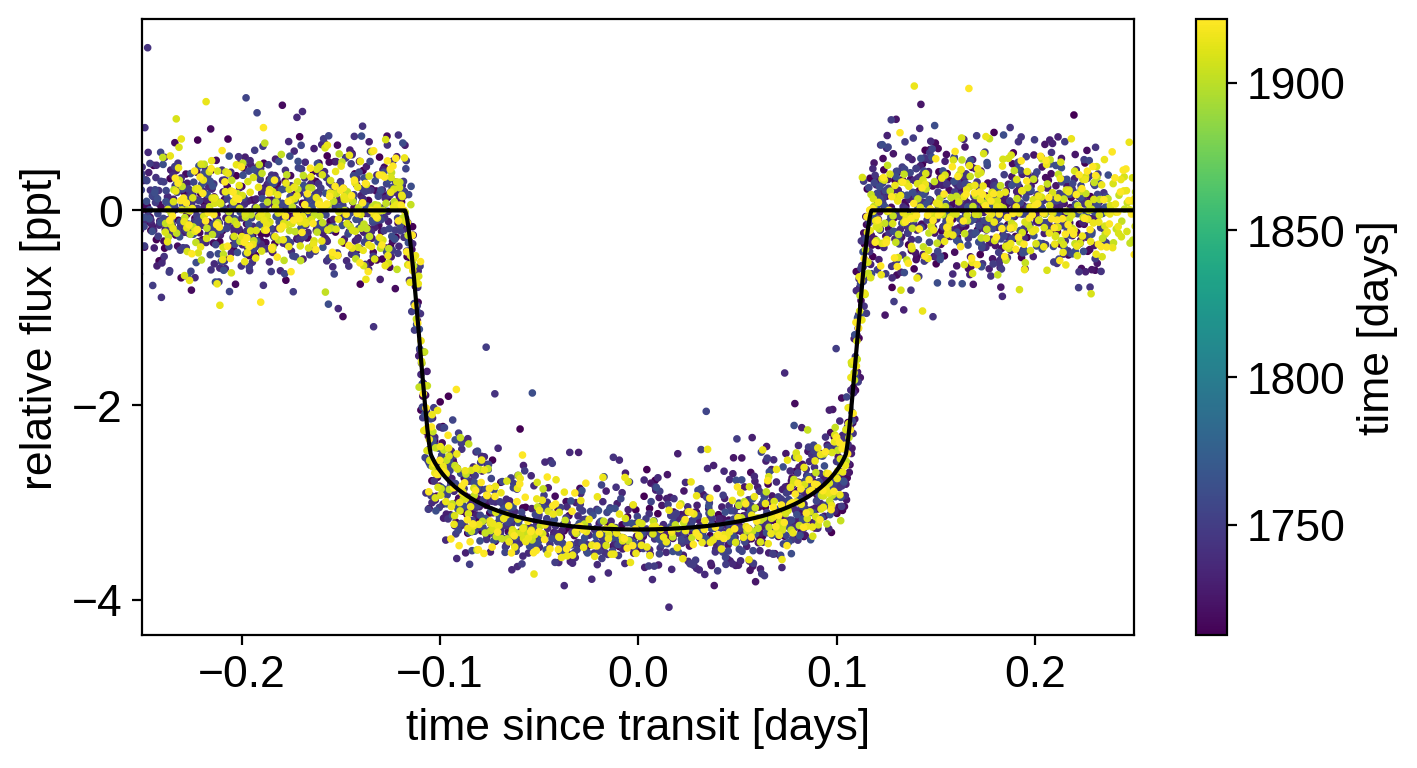

In [7]:
with model:
    gp_pred, lc_pred = xo.eval_in_model([gp.predict(), lc_model(x)], map_soln)

plt.figure(figsize=(8, 4))
x_fold = (x - map_soln["t0"] + 0.5 * map_soln["period"]) % map_soln[
    "period"
] - 0.5 * map_soln["period"]
inds = np.argsort(x_fold)
plt.scatter(x_fold, y - gp_pred - map_soln["mean"], c=x, s=3)
plt.plot(x_fold[inds], lc_pred[inds] - map_soln["mean"], "k")
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
plt.xlim(-0.25, 0.25);

That looks better!

Now on to sampling:

In [8]:
np.random.seed(721)
with model:
    trace = pm.sample(
        tune=2000,
        draws=2000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [b, log_dur, t0, log_period, log_ror, log_w0, log_Sw4, sigma, u, mean]


Sampling 4 chains, 0 divergences:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 21/16000 [00:00<07:05, 37.55draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 25/16000 [00:01<15:22, 17.32draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 29/16000 [00:01<20:12, 13.17draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 30/16000 [00:01<22:17, 11.94draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 33/16000 [00:02<25:15, 10.54draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 34/16000 [00:02<28:21,  9.38draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 37/16000 [00:02<29:12,  9.11draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 38/16000 [00:02<34:15,  7.76draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 41/16000 [00:03<34:22,  7.74draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 43/16000 [00:03<30:37,  8.68draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 45/16000 [00:03<35:59,  7.39draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 46/16000 [00:03<34:28,  7.71draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 47/16000 [00:03<33:00,  8.06draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 49/16000 [00:03<27:42,  9.60draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 51/16000 [00:04<31:01,  8.57draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 52/16000 [00:04<30:57,  8.59draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 54/16000 [00:04<35:27,  7.49draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 56/16000 [00:04<32:59,  8.06draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 58/16000 [00:05<35:36,  7.46draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 60/16000 [00:05<32:18,  8.22draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 61/16000 [00:05<33:53,  7.84draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 62/16000 [00:05<40:29,  6.56draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 64/16000 [00:05<34:38,  7.67draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 65/16000 [00:06<36:39,  7.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 66/16000 [00:06<40:22,  6.58draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 68/16000 [00:06<33:08,  8.01draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 70/16000 [00:06<37:41,  7.04draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 72/16000 [00:06<31:34,  8.41draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 74/16000 [00:07<31:53,  8.32draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 75/16000 [00:07<37:41,  7.04draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 77/16000 [00:07<31:24,  8.45draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 79/16000 [00:07<39:56,  6.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 82/16000 [00:08<37:38,  7.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 83/16000 [00:08<38:54,  6.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 86/16000 [00:08<36:30,  7.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 87/16000 [00:08<38:30,  6.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 90/16000 [00:09<35:47,  7.41draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 91/16000 [00:09<40:03,  6.62draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 94/16000 [00:09<37:08,  7.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 95/16000 [00:09<41:09,  6.44draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 98/16000 [00:10<37:18,  7.11draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 99/16000 [00:10<41:36,  6.37draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 101/16000 [00:10<35:00,  7.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 102/16000 [00:10<36:11,  7.32draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 103/16000 [00:11<44:04,  6.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 105/16000 [00:11<35:18,  7.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 107/16000 [00:11<32:32,  8.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 109/16000 [00:11<32:43,  8.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 111/16000 [00:11<36:03,  7.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 112/16000 [00:12<37:41,  7.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 115/16000 [00:12<37:20,  7.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 117/16000 [00:12<30:34,  8.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 119/16000 [00:13<38:41,  6.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 122/16000 [00:13<34:54,  7.58draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 123/16000 [00:13<40:41,  6.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 125/16000 [00:13<34:12,  7.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 126/16000 [00:13<44:12,  5.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 127/16000 [00:14<40:16,  6.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 129/16000 [00:14<34:36,  7.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 130/16000 [00:14<47:48,  5.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/16000 [00:14<37:46,  7.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 134/16000 [00:15<42:12,  6.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 137/16000 [00:15<32:30,  8.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 139/16000 [00:15<38:15,  6.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 141/16000 [00:15<30:50,  8.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 143/16000 [00:16<38:06,  6.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 145/16000 [00:16<32:20,  8.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 147/16000 [00:16<38:36,  6.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 149/16000 [00:16<34:46,  7.60draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 151/16000 [00:17<38:57,  6.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 153/16000 [00:17<32:59,  8.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 155/16000 [00:17<37:39,  7.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 156/16000 [00:17<35:13,  7.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 158/16000 [00:17<33:15,  7.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 159/16000 [00:18<35:10,  7.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 160/16000 [00:18<36:43,  7.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 162/16000 [00:18<34:19,  7.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 164/16000 [00:18<29:04,  9.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 166/16000 [00:18<28:40,  9.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/16000 [00:19<32:01,  8.24draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 169/16000 [00:19<35:33,  7.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 171/16000 [00:19<38:27,  6.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 173/16000 [00:19<36:24,  7.24draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 175/16000 [00:20<38:41,  6.82draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 177/16000 [00:20<36:36,  7.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 179/16000 [00:20<36:12,  7.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 181/16000 [00:21<36:11,  7.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 183/16000 [00:21<34:06,  7.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 184/16000 [00:21<34:05,  7.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 185/16000 [00:21<35:42,  7.38draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 187/16000 [00:21<35:35,  7.40draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 189/16000 [00:21<33:14,  7.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 191/16000 [00:22<34:59,  7.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 193/16000 [00:22<31:59,  8.23draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 195/16000 [00:22<34:08,  7.71draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 197/16000 [00:22<32:04,  8.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 199/16000 [00:23<34:09,  7.71draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 200/16000 [00:23<33:12,  7.93draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 201/16000 [00:23<32:01,  8.22draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 203/16000 [00:23<34:30,  7.63draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 205/16000 [00:23<31:16,  8.42draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 207/16000 [00:24<37:03,  7.10draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 210/16000 [00:24<32:10,  8.18draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 211/16000 [00:24<42:20,  6.22draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 213/16000 [00:25<35:08,  7.49draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 214/16000 [00:25<36:33,  7.20draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 215/16000 [00:25<40:05,  6.56draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 216/16000 [00:25<39:54,  6.59draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 218/16000 [00:25<38:24,  6.85draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 220/16000 [00:25<35:21,  7.44draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 222/16000 [00:26<38:10,  6.89draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 224/16000 [00:26<34:17,  7.67draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 226/16000 [00:26<35:44,  7.35draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 228/16000 [00:27<33:17,  7.90draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 229/16000 [00:27<34:00,  7.73draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 230/16000 [00:27<33:20,  7.88draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 232/16000 [00:27<35:52,  7.32draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 234/16000 [00:27<34:45,  7.56draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 236/16000 [00:28<37:29,  7.01draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 238/16000 [00:28<33:27,  7.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 240/16000 [00:28<35:58,  7.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 242/16000 [00:28<33:43,  7.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 244/16000 [00:29<36:08,  7.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 246/16000 [00:29<33:02,  7.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 247/16000 [00:29<31:55,  8.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 248/16000 [00:29<38:01,  6.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 249/16000 [00:29<35:56,  7.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 251/16000 [00:29<31:38,  8.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 252/16000 [00:30<38:36,  6.80draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 253/16000 [00:30<41:44,  6.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 255/16000 [00:30<34:07,  7.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 256/16000 [00:30<41:48,  6.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 257/16000 [00:30<42:18,  6.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 259/16000 [00:31<39:04,  6.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 261/16000 [00:31<39:19,  6.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 263/16000 [00:31<34:42,  7.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 264/16000 [00:31<36:55,  7.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 265/16000 [00:31<39:27,  6.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 267/16000 [00:32<36:51,  7.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 268/16000 [00:32<39:15,  6.68draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 269/16000 [00:32<37:38,  6.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 271/16000 [00:32<34:06,  7.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 272/16000 [00:32<37:24,  7.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 273/16000 [00:33<42:30,  6.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 275/16000 [00:33<34:52,  7.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 276/16000 [00:33<37:24,  7.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 277/16000 [00:33<42:28,  6.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 279/16000 [00:33<34:57,  7.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 280/16000 [00:33<37:05,  7.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 281/16000 [00:34<41:59,  6.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 282/16000 [00:34<37:42,  6.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 284/16000 [00:34<33:20,  7.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 285/16000 [00:34<39:19,  6.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 286/16000 [00:34<37:25,  7.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 288/16000 [00:34<31:44,  8.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 289/16000 [00:35<38:16,  6.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 290/16000 [00:35<38:22,  6.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 292/16000 [00:35<32:27,  8.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 293/16000 [00:35<40:44,  6.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 294/16000 [00:35<40:54,  6.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 295/16000 [00:35<38:03,  6.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 297/16000 [00:36<35:41,  7.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 298/16000 [00:36<42:30,  6.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 301/16000 [00:36<38:23,  6.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 302/16000 [00:36<40:53,  6.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 305/16000 [00:37<36:48,  7.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 306/16000 [00:37<41:21,  6.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 308/16000 [00:37<33:59,  7.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 309/16000 [00:37<37:10,  7.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 310/16000 [00:37<40:58,  6.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 312/16000 [00:37<34:38,  7.55draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 313/16000 [00:38<35:32,  7.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 314/16000 [00:38<41:41,  6.27draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 316/16000 [00:38<34:57,  7.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 317/16000 [00:38<33:55,  7.71draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 318/16000 [00:38<42:02,  6.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 320/16000 [00:39<38:54,  6.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 322/16000 [00:39<36:02,  7.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 324/16000 [00:39<35:29,  7.36draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 326/16000 [00:39<32:59,  7.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 327/16000 [00:39<35:49,  7.29draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 328/16000 [00:40<36:51,  7.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 330/16000 [00:40<33:19,  7.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 331/16000 [00:40<45:09,  5.78draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 333/16000 [00:40<38:48,  6.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 335/16000 [00:41<40:20,  6.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 337/16000 [00:41<37:37,  6.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 339/16000 [00:41<36:26,  7.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 341/16000 [00:41<34:30,  7.56draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 342/16000 [00:41<34:45,  7.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 343/16000 [00:42<34:08,  7.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 345/16000 [00:42<32:40,  7.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 346/16000 [00:42<35:48,  7.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 347/16000 [00:42<35:07,  7.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 349/16000 [00:42<31:51,  8.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 350/16000 [00:42<40:37,  6.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 353/16000 [00:43<31:51,  8.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 355/16000 [00:43<38:40,  6.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 358/16000 [00:43<30:47,  8.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 360/16000 [00:44<38:01,  6.86draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 363/16000 [00:44<37:36,  6.93draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 365/16000 [00:44<30:52,  8.44draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 367/16000 [00:45<36:07,  7.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 368/16000 [00:45<34:16,  7.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 370/16000 [00:45<28:45,  9.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 372/16000 [00:45<35:17,  7.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 374/16000 [00:45<29:45,  8.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 376/16000 [00:46<34:35,  7.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 378/16000 [00:46<30:55,  8.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 380/16000 [00:46<35:03,  7.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 381/16000 [00:46<33:18,  7.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 383/16000 [00:47<34:35,  7.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 385/16000 [00:47<34:32,  7.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 387/16000 [00:47<35:22,  7.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 389/16000 [00:47<33:12,  7.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 390/16000 [00:47<31:03,  8.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 391/16000 [00:48<39:12,  6.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 393/16000 [00:48<35:36,  7.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 395/16000 [00:48<36:38,  7.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 397/16000 [00:48<33:36,  7.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 399/16000 [00:49<34:53,  7.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 401/16000 [00:49<33:37,  7.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 403/16000 [00:49<34:22,  7.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 405/16000 [00:49<33:24,  7.78draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 407/16000 [00:50<36:14,  7.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 409/16000 [00:50<32:13,  8.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 410/16000 [00:50<31:11,  8.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 411/16000 [00:50<37:33,  6.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 413/16000 [00:50<35:06,  7.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 414/16000 [00:51<35:31,  7.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 415/16000 [00:51<34:03,  7.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 417/16000 [00:51<34:45,  7.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 418/16000 [00:51<37:16,  6.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 419/16000 [00:51<34:13,  7.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 421/16000 [00:52<35:28,  7.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 422/16000 [00:52<33:06,  7.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 423/16000 [00:52<34:51,  7.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 425/16000 [00:52<33:19,  7.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 426/16000 [00:52<32:52,  7.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 427/16000 [00:52<36:56,  7.03draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 429/16000 [00:53<33:46,  7.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 430/16000 [00:53<39:51,  6.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 432/16000 [00:53<33:09,  7.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 433/16000 [00:53<37:40,  6.89draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 434/16000 [00:53<39:58,  6.49draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 436/16000 [00:53<33:26,  7.76draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 437/16000 [00:54<46:38,  5.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 440/16000 [00:54<37:19,  6.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 442/16000 [00:54<39:58,  6.49draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 444/16000 [00:54<35:01,  7.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 445/16000 [00:55<50:07,  5.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 448/16000 [00:55<38:58,  6.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 450/16000 [00:55<43:22,  5.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 453/16000 [00:56<42:22,  6.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 455/16000 [00:56<33:50,  7.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 457/16000 [00:56<42:07,  6.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 460/16000 [00:56<32:33,  7.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 462/16000 [00:57<37:42,  6.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 464/16000 [00:57<33:25,  7.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 466/16000 [00:57<37:46,  6.85draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 468/16000 [00:58<31:30,  8.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 470/16000 [00:58<38:31,  6.72draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 473/16000 [00:58<36:07,  7.16draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 474/16000 [00:58<35:14,  7.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 476/16000 [00:59<30:14,  8.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 478/16000 [00:59<35:50,  7.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 480/16000 [00:59<32:30,  7.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 481/16000 [00:59<39:06,  6.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 482/16000 [00:59<37:14,  6.94draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 484/16000 [01:00<32:42,  7.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 485/16000 [01:00<38:50,  6.66draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 486/16000 [01:00<39:44,  6.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 488/16000 [01:00<32:24,  7.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 490/16000 [01:01<38:36,  6.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 493/16000 [01:01<35:24,  7.30draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 494/16000 [01:01<39:04,  6.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 497/16000 [01:01<34:59,  7.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 498/16000 [01:02<37:57,  6.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 499/16000 [01:02<35:03,  7.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 500/16000 [01:02<34:52,  7.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 501/16000 [01:02<32:58,  7.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 502/16000 [01:02<34:27,  7.50draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 503/16000 [01:02<39:27,  6.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 505/16000 [01:02<33:14,  7.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 506/16000 [01:02<33:13,  7.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 507/16000 [01:03<47:20,  5.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 510/16000 [01:03<37:34,  6.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 512/16000 [01:03<40:40,  6.35draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 514/16000 [01:03<33:04,  7.80draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 516/16000 [01:04<37:30,  6.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 518/16000 [01:04<31:01,  8.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 520/16000 [01:04<37:20,  6.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 522/16000 [01:04<30:32,  8.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 524/16000 [01:05<37:01,  6.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 526/16000 [01:05<29:52,  8.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 528/16000 [01:05<36:32,  7.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 530/16000 [01:06<31:02,  8.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 532/16000 [01:06<34:19,  7.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 533/16000 [01:06<36:02,  7.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 535/16000 [01:06<35:24,  7.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 537/16000 [01:07<37:06,  6.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 539/16000 [01:07<32:19,  7.97draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 540/16000 [01:07<30:45,  8.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 541/16000 [01:07<41:16,  6.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 543/16000 [01:07<33:48,  7.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 545/16000 [01:08<37:29,  6.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 546/16000 [01:08<41:19,  6.23draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 549/16000 [01:08<37:38,  6.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 550/16000 [01:08<40:42,  6.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 553/16000 [01:09<35:49,  7.19draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 554/16000 [01:09<42:26,  6.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 557/16000 [01:09<36:42,  7.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 558/16000 [01:09<41:13,  6.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 561/16000 [01:10<37:57,  6.78draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 562/16000 [01:10<38:10,  6.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 564/16000 [01:10<31:16,  8.22draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 566/16000 [01:10<36:08,  7.12draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 568/16000 [01:10<33:10,  7.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 569/16000 [01:11<37:36,  6.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 571/16000 [01:11<35:08,  7.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 572/16000 [01:11<40:13,  6.39draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 574/16000 [01:11<36:22,  7.07draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 576/16000 [01:12<38:58,  6.60draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 578/16000 [01:12<33:38,  7.64draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 580/16000 [01:12<38:04,  6.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 582/16000 [01:12<32:02,  8.02draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 584/16000 [01:13<37:21,  6.88draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 586/16000 [01:13<30:42,  8.36draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 588/16000 [01:13<37:05,  6.93draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 591/16000 [01:13<30:59,  8.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 593/16000 [01:14<32:07,  7.99draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 595/16000 [01:14<29:35,  8.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 597/16000 [01:14<32:45,  7.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 599/16000 [01:14<31:28,  8.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 601/16000 [01:15<34:34,  7.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 603/16000 [01:15<31:16,  8.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 605/16000 [01:15<35:09,  7.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 607/16000 [01:15<31:09,  8.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 609/16000 [01:16<35:50,  7.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 611/16000 [01:16<30:38,  8.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 613/16000 [01:16<35:13,  7.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 615/16000 [01:17<31:29,  8.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 617/16000 [01:17<34:15,  7.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 619/16000 [01:17<29:54,  8.57draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 620/16000 [01:17<30:00,  8.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 621/16000 [01:17<40:11,  6.38draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 623/16000 [01:18<34:51,  7.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 625/16000 [01:18<31:17,  8.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 627/16000 [01:18<25:54,  9.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 629/16000 [01:18<34:32,  7.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 632/16000 [01:18<27:13,  9.41draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 634/16000 [01:19<34:58,  7.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 636/16000 [01:19<30:34,  8.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 638/16000 [01:19<37:05,  6.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 641/16000 [01:19<29:26,  8.70draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 643/16000 [01:20<37:02,  6.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 646/16000 [01:20<29:48,  8.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 648/16000 [01:20<36:19,  7.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 651/16000 [01:21<32:38,  7.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 653/16000 [01:21<27:52,  9.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 656/16000 [01:21<22:19, 11.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 659/16000 [01:21<26:55,  9.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 661/16000 [01:22<23:48, 10.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 664/16000 [01:22<25:17, 10.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 666/16000 [01:22<26:28,  9.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 670/16000 [01:22<20:35, 12.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 672/16000 [01:22<22:50, 11.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 674/16000 [01:23<24:13, 10.55draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 678/16000 [01:23<20:22, 12.54draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 680/16000 [01:23<21:51, 11.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 682/16000 [01:23<23:47, 10.73draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 686/16000 [01:23<18:46, 13.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 690/16000 [01:24<15:38, 16.32draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 693/16000 [01:24<13:42, 18.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 696/16000 [01:24<13:02, 19.57draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 700/16000 [01:24<11:13, 22.73draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 704/16000 [01:24<11:03, 23.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 709/16000 [01:24<09:28, 26.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 717/16000 [01:24<07:44, 32.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 722/16000 [01:24<07:11, 35.44draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 730/16000 [01:24<06:03, 42.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 736/16000 [01:25<06:11, 41.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 748/16000 [01:25<05:04, 50.01draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 758/16000 [01:25<04:21, 58.18draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 767/16000 [01:25<04:03, 62.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 776/16000 [01:25<03:47, 67.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 784/16000 [01:25<03:51, 65.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 792/16000 [01:25<03:48, 66.57draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 801/16000 [01:25<03:31, 71.78draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 811/16000 [01:26<03:15, 77.66draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 822/16000 [01:26<03:01, 83.75draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 834/16000 [01:26<02:45, 91.72draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 850/16000 [01:26<02:24, 104.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 862/16000 [01:26<02:29, 101.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 873/16000 [01:26<02:26, 103.18draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 888/16000 [01:26<02:13, 113.21draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 904/16000 [01:26<02:03, 122.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 920/16000 [01:26<01:54, 131.87draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 934/16000 [01:27<02:01, 123.71draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 947/16000 [01:27<02:01, 123.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 960/16000 [01:27<02:02, 123.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 976/16000 [01:27<01:56, 129.15draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 993/16000 [01:27<01:48, 138.94draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1008/16000 [01:27<01:46, 141.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1023/16000 [01:27<01:47, 139.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1038/16000 [01:27<01:46, 139.95draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1053/16000 [01:27<01:50, 134.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1068/16000 [01:27<01:49, 136.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1089/16000 [01:28<01:38, 150.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1105/16000 [01:28<01:37, 153.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1121/16000 [01:28<01:36, 154.46draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1137/16000 [01:28<01:35, 155.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1153/16000 [01:28<01:36, 153.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1174/16000 [01:28<01:29, 165.84draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1191/16000 [01:28<01:30, 163.43draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1208/16000 [01:28<01:36, 152.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1225/16000 [01:28<01:33, 157.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1242/16000 [01:29<01:32, 160.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1259/16000 [01:29<01:33, 158.34draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1275/16000 [01:29<01:34, 155.17draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1291/16000 [01:29<01:37, 150.41draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1308/16000 [01:29<01:35, 154.07draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1328/16000 [01:29<01:32, 158.83draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1344/16000 [01:29<01:35, 153.20draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1361/16000 [01:29<01:35, 152.60draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1377/16000 [01:29<01:35, 152.61draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 1393/16000 [01:30<01:35, 153.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1409/16000 [01:30<01:51, 130.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1423/16000 [01:30<01:49, 132.54draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1437/16000 [01:30<01:51, 130.70draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1454/16000 [01:30<01:45, 137.90draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1469/16000 [01:30<01:53, 128.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1483/16000 [01:30<02:01, 119.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1496/16000 [01:30<02:03, 117.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 1510/16000 [01:31<01:58, 121.93draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1524/16000 [01:31<01:54, 126.66draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1539/16000 [01:31<01:49, 131.52draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1553/16000 [01:31<01:54, 126.71draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1570/16000 [01:31<01:46, 135.18draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 1587/16000 [01:31<01:44, 137.97draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1602/16000 [01:31<01:52, 128.22draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1620/16000 [01:31<01:44, 137.14draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1635/16000 [01:31<01:54, 125.63draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1649/16000 [01:32<01:55, 123.88draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1662/16000 [01:32<01:59, 120.06draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 1675/16000 [01:32<02:06, 113.52draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1691/16000 [01:32<01:57, 122.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1705/16000 [01:32<01:53, 126.30draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1720/16000 [01:32<01:48, 131.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1736/16000 [01:32<01:43, 137.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1751/16000 [01:32<01:49, 130.29draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1770/16000 [01:32<01:40, 141.63draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 1786/16000 [01:33<01:37, 146.43draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1804/16000 [01:33<01:33, 152.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1822/16000 [01:33<01:30, 156.25draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 1839/16000 [01:33<01:29, 158.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1856/16000 [01:33<01:31, 153.83draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1873/16000 [01:33<01:29, 158.15draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1889/16000 [01:33<01:30, 155.91draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1905/16000 [01:33<01:30, 155.51draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1921/16000 [01:33<01:40, 139.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1936/16000 [01:34<01:42, 137.03draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1951/16000 [01:34<01:40, 140.03draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1966/16000 [01:34<01:38, 142.78draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 1985/16000 [01:34<01:32, 150.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2003/16000 [01:34<01:29, 157.16draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2019/16000 [01:34<01:33, 150.22draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2035/16000 [01:34<01:40, 139.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2051/16000 [01:34<01:40, 139.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2066/16000 [01:34<01:38, 140.94draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2083/16000 [01:35<01:33, 148.14draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2103/16000 [01:35<01:28, 156.43draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2122/16000 [01:35<01:25, 162.69draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2139/16000 [01:35<01:26, 160.74draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 2156/16000 [01:35<01:30, 153.37draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2172/16000 [01:35<01:37, 141.87draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 2188/16000 [01:35<01:37, 141.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2207/16000 [01:35<01:29, 153.49draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2223/16000 [01:35<01:29, 154.40draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2239/16000 [01:36<01:30, 151.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2258/16000 [01:36<01:28, 155.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2274/16000 [01:36<01:28, 154.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2290/16000 [01:36<01:36, 142.48draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 2305/16000 [01:36<01:34, 144.62draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2321/16000 [01:36<01:33, 146.63draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2337/16000 [01:36<01:31, 148.89draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2353/16000 [01:36<01:33, 146.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2368/16000 [01:36<01:44, 130.24draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2383/16000 [01:37<01:40, 135.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 2397/16000 [01:37<01:41, 133.60draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2414/16000 [01:37<01:35, 142.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2429/16000 [01:37<01:39, 137.04draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2443/16000 [01:37<01:40, 135.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2458/16000 [01:37<01:37, 138.98draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 2475/16000 [01:37<01:32, 145.61draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2490/16000 [01:37<01:34, 143.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2506/16000 [01:37<01:34, 143.04draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2524/16000 [01:38<01:28, 151.63draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2540/16000 [01:38<01:34, 143.06draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2555/16000 [01:38<01:33, 143.81draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2573/16000 [01:38<01:27, 152.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 2589/16000 [01:38<01:31, 146.17draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2604/16000 [01:38<01:36, 139.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2619/16000 [01:38<01:37, 137.19draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 2633/16000 [01:38<01:40, 132.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2647/16000 [01:38<01:39, 134.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2663/16000 [01:39<01:38, 134.92draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2679/16000 [01:39<01:37, 136.98draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2693/16000 [01:39<01:39, 134.33draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2708/16000 [01:39<01:38, 134.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2722/16000 [01:39<01:40, 132.14draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2736/16000 [01:39<01:41, 130.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2750/16000 [01:39<01:43, 127.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2763/16000 [01:39<01:44, 126.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2777/16000 [01:39<01:41, 130.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 2794/16000 [01:40<01:35, 138.44draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2811/16000 [01:40<01:30, 145.28draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2826/16000 [01:40<01:31, 143.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2842/16000 [01:40<01:30, 145.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2858/16000 [01:40<01:31, 143.78draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2875/16000 [01:40<01:27, 149.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2891/16000 [01:40<01:29, 146.70draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2906/16000 [01:40<01:30, 144.11draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2924/16000 [01:40<01:26, 151.05draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2942/16000 [01:41<01:23, 155.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 2958/16000 [01:41<01:27, 149.08draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2974/16000 [01:41<01:31, 142.83draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 2990/16000 [01:41<01:28, 146.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3005/16000 [01:41<01:33, 138.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3020/16000 [01:41<01:31, 141.83draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3035/16000 [01:41<01:33, 138.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3051/16000 [01:41<01:31, 141.85draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3066/16000 [01:41<01:30, 142.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3082/16000 [01:42<01:31, 141.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3097/16000 [01:42<01:36, 133.68draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 3114/16000 [01:42<01:32, 139.57draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3129/16000 [01:42<01:32, 139.81draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3144/16000 [01:42<01:35, 134.89draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3158/16000 [01:42<01:39, 128.80draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3172/16000 [01:42<01:39, 128.63draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3185/16000 [01:42<01:53, 112.53draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 3197/16000 [01:42<02:04, 102.45draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3208/16000 [01:43<02:03, 103.59draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3223/16000 [01:43<01:54, 111.73draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3235/16000 [01:43<01:53, 112.67draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3247/16000 [01:43<01:57, 108.89draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3261/16000 [01:43<01:51, 114.39draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 3275/16000 [01:43<01:46, 119.30draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3288/16000 [01:43<01:45, 120.26draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3302/16000 [01:43<01:41, 125.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3317/16000 [01:43<01:38, 128.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3331/16000 [01:44<01:41, 124.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3344/16000 [01:44<01:40, 126.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3357/16000 [01:44<01:44, 120.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3370/16000 [01:44<01:46, 118.18draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3385/16000 [01:44<01:42, 123.52draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 3398/16000 [01:44<01:42, 123.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3411/16000 [01:44<01:47, 116.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3425/16000 [01:44<01:44, 119.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 3439/16000 [01:44<01:42, 123.10draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3452/16000 [01:45<01:41, 123.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3466/16000 [01:45<01:38, 127.48draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3479/16000 [01:45<01:41, 123.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3492/16000 [01:45<01:42, 121.53draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3505/16000 [01:45<01:45, 117.94draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3520/16000 [01:45<01:41, 122.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3533/16000 [01:45<01:46, 116.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3547/16000 [01:45<01:44, 118.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3560/16000 [01:45<01:44, 119.55draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3574/16000 [01:46<01:39, 125.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 3590/16000 [01:46<01:34, 131.41draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3604/16000 [01:46<01:36, 127.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3618/16000 [01:46<01:35, 129.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3633/16000 [01:46<01:33, 132.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3647/16000 [01:46<01:38, 125.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3660/16000 [01:46<01:38, 125.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3673/16000 [01:46<01:45, 116.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3685/16000 [01:46<01:51, 110.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3698/16000 [01:47<01:47, 114.29draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3711/16000 [01:47<01:44, 117.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3723/16000 [01:47<01:44, 117.22draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3735/16000 [01:47<01:45, 116.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3747/16000 [01:47<01:44, 117.06draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 3759/16000 [01:47<01:43, 117.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3771/16000 [01:47<01:43, 117.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3786/16000 [01:47<01:37, 125.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 3799/16000 [01:47<01:40, 121.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3812/16000 [01:48<01:43, 117.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3824/16000 [01:48<01:44, 117.07draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3836/16000 [01:48<01:43, 117.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3849/16000 [01:48<01:41, 120.28draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3862/16000 [01:48<01:40, 120.44draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3875/16000 [01:48<01:44, 116.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3888/16000 [01:48<01:48, 111.59draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3902/16000 [01:48<01:45, 114.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 3915/16000 [01:48<01:42, 118.22draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3927/16000 [01:49<01:43, 116.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3939/16000 [01:49<01:44, 115.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3952/16000 [01:49<01:41, 118.53draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3968/16000 [01:49<01:34, 127.48draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3981/16000 [01:49<01:41, 118.74draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 3994/16000 [01:49<01:40, 119.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4008/16000 [01:49<01:42, 116.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4021/16000 [01:49<01:41, 118.03draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4033/16000 [01:49<01:42, 116.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4045/16000 [01:50<01:43, 115.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4057/16000 [01:50<01:42, 116.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 4073/16000 [01:50<01:39, 119.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4087/16000 [01:50<01:36, 122.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4102/16000 [01:50<01:33, 127.79draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4115/16000 [01:50<01:32, 128.32draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4128/16000 [01:50<01:35, 124.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4141/16000 [01:50<01:34, 125.95draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4154/16000 [01:50<01:36, 122.67draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4168/16000 [01:50<01:33, 126.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4183/16000 [01:51<01:32, 127.31draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 4196/16000 [01:51<01:34, 124.40draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4209/16000 [01:51<01:37, 120.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4222/16000 [01:51<01:38, 120.02draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 4235/16000 [01:51<01:43, 113.65draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4248/16000 [01:51<01:42, 114.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4260/16000 [01:51<01:46, 110.71draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4273/16000 [01:51<01:44, 112.24draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4286/16000 [01:52<01:41, 115.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4298/16000 [01:52<01:40, 116.04draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4310/16000 [01:52<01:42, 114.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4322/16000 [01:52<01:41, 115.04draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4336/16000 [01:52<01:36, 121.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4349/16000 [01:52<01:35, 121.65draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4362/16000 [01:52<01:34, 123.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4375/16000 [01:52<01:34, 122.68draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 4388/16000 [01:52<01:35, 121.51draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4405/16000 [01:52<01:29, 129.57draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4419/16000 [01:53<01:27, 132.36draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4433/16000 [01:53<01:27, 131.50draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4447/16000 [01:53<01:35, 120.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4462/16000 [01:53<01:30, 127.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4475/16000 [01:53<01:38, 117.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4489/16000 [01:53<01:36, 118.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4502/16000 [01:53<01:34, 121.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4516/16000 [01:53<01:31, 125.47draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4530/16000 [01:53<01:30, 127.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4544/16000 [01:54<01:28, 129.29draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 4559/16000 [01:54<01:29, 128.10draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4575/16000 [01:54<01:27, 129.95draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 4589/16000 [01:54<01:28, 129.53draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4605/16000 [01:54<01:23, 135.91draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4619/16000 [01:54<01:24, 135.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4633/16000 [01:54<01:24, 134.52draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4647/16000 [01:54<01:29, 126.44draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4660/16000 [01:54<01:34, 120.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4675/16000 [01:55<01:30, 124.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4689/16000 [01:55<01:27, 128.68draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4703/16000 [01:55<01:30, 124.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 4716/16000 [01:55<01:34, 119.79draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4729/16000 [01:55<01:37, 116.03draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4743/16000 [01:55<01:34, 119.33draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4757/16000 [01:55<01:32, 122.00draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4771/16000 [01:55<01:28, 126.41draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4784/16000 [01:55<01:28, 127.44draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 4797/16000 [01:56<01:30, 123.68draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4810/16000 [01:56<01:32, 120.88draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4825/16000 [01:56<01:27, 127.91draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4838/16000 [01:56<01:30, 123.11draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4851/16000 [01:56<01:29, 124.21draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4864/16000 [01:56<01:29, 123.78draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 4879/16000 [01:56<01:25, 130.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4893/16000 [01:56<01:24, 130.97draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4907/16000 [01:56<01:26, 127.92draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4922/16000 [01:57<01:23, 133.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4936/16000 [01:57<01:24, 131.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4950/16000 [01:57<01:24, 131.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4964/16000 [01:57<01:22, 133.05draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4979/16000 [01:57<01:20, 136.63draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 4994/16000 [01:57<01:18, 140.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5009/16000 [01:57<01:18, 140.58draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5024/16000 [01:57<01:20, 135.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 5039/16000 [01:57<01:23, 131.52draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5053/16000 [01:58<01:22, 132.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5067/16000 [01:58<01:21, 134.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5081/16000 [01:58<01:20, 134.91draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5095/16000 [01:58<01:28, 123.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5108/16000 [01:58<01:30, 120.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5122/16000 [01:58<01:27, 124.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5135/16000 [01:58<01:28, 122.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5150/16000 [01:58<01:23, 129.32draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5166/16000 [01:58<01:19, 136.51draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5180/16000 [01:58<01:19, 136.16draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 5194/16000 [01:59<01:20, 134.34draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5208/16000 [01:59<01:20, 134.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5222/16000 [01:59<01:19, 134.81draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5237/16000 [01:59<01:18, 137.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5252/16000 [01:59<01:17, 138.66draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5266/16000 [01:59<01:17, 138.35draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5281/16000 [01:59<01:18, 136.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5297/16000 [01:59<01:18, 136.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5312/16000 [01:59<01:19, 134.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5327/16000 [02:00<01:18, 136.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5341/16000 [02:00<01:19, 133.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 5356/16000 [02:00<01:17, 137.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5371/16000 [02:00<01:15, 140.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 5386/16000 [02:00<01:18, 135.04draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5400/16000 [02:00<01:19, 133.93draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5414/16000 [02:00<01:23, 126.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5427/16000 [02:00<01:26, 122.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5440/16000 [02:00<01:25, 123.49draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5455/16000 [02:01<01:21, 130.14draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5469/16000 [02:01<01:19, 132.92draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5484/16000 [02:01<01:19, 132.80draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5500/16000 [02:01<01:15, 139.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 5515/16000 [02:01<01:19, 131.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5529/16000 [02:01<01:19, 131.66draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5543/16000 [02:01<01:24, 124.31draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5558/16000 [02:01<01:20, 129.13draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5573/16000 [02:01<01:18, 132.07draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 5588/16000 [02:02<01:16, 136.98draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5603/16000 [02:02<01:16, 135.42draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5620/16000 [02:02<01:14, 140.19draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5635/16000 [02:02<01:12, 142.36draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5650/16000 [02:02<01:14, 138.48draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5664/16000 [02:02<01:14, 138.74draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 5679/16000 [02:02<01:12, 141.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5694/16000 [02:02<01:14, 138.26draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5711/16000 [02:02<01:11, 143.42draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5726/16000 [02:03<01:11, 144.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5742/16000 [02:03<01:09, 148.63draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5757/16000 [02:03<01:11, 143.12draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5772/16000 [02:03<01:14, 137.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 5786/16000 [02:03<01:17, 132.10draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5800/16000 [02:03<01:21, 125.07draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5813/16000 [02:03<01:24, 120.84draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 5827/16000 [02:03<01:22, 122.68draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5844/16000 [02:03<01:18, 129.87draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5858/16000 [02:04<01:16, 132.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5873/16000 [02:04<01:15, 134.32draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5887/16000 [02:04<01:14, 135.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5901/16000 [02:04<01:15, 133.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5916/16000 [02:04<01:12, 138.23draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5933/16000 [02:04<01:12, 139.42draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5950/16000 [02:04<01:08, 147.13draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5965/16000 [02:04<01:10, 141.39draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5981/16000 [02:04<01:10, 142.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 5996/16000 [02:05<01:12, 137.55draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6012/16000 [02:05<01:09, 143.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6027/16000 [02:05<01:08, 144.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6042/16000 [02:05<01:10, 140.70draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6057/16000 [02:05<01:12, 137.82draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6071/16000 [02:05<01:14, 133.40draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6086/16000 [02:05<01:13, 134.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6101/16000 [02:05<01:12, 136.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6117/16000 [02:05<01:09, 142.41draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6133/16000 [02:05<01:09, 142.12draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 6151/16000 [02:06<01:07, 146.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6167/16000 [02:06<01:05, 149.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6183/16000 [02:06<01:04, 151.78draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 6199/16000 [02:06<01:06, 148.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6215/16000 [02:06<01:05, 149.93draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6231/16000 [02:06<01:06, 146.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6246/16000 [02:06<01:07, 143.84draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6261/16000 [02:06<01:08, 141.19draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6277/16000 [02:06<01:09, 140.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6293/16000 [02:07<01:08, 141.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 6308/16000 [02:07<01:08, 142.04draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6323/16000 [02:07<01:10, 136.82draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6338/16000 [02:07<01:11, 134.40draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6354/16000 [02:07<01:11, 134.72draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6370/16000 [02:07<01:10, 135.89draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6384/16000 [02:07<01:12, 133.12draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 6398/16000 [02:07<01:12, 132.28draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6412/16000 [02:07<01:11, 133.95draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6426/16000 [02:08<01:13, 130.86draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6440/16000 [02:08<01:11, 133.38draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6454/16000 [02:08<01:10, 134.56draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 6468/16000 [02:08<01:11, 133.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6484/16000 [02:08<01:10, 134.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6500/16000 [02:08<01:09, 137.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6514/16000 [02:08<01:08, 137.71draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6531/16000 [02:08<01:06, 141.48draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6546/16000 [02:08<01:05, 143.48draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6561/16000 [02:09<01:09, 134.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6576/16000 [02:09<01:09, 136.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 6590/16000 [02:09<01:14, 126.45draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6604/16000 [02:09<01:14, 125.29draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6618/16000 [02:09<01:13, 127.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 6632/16000 [02:09<01:12, 129.93draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6646/16000 [02:09<01:10, 131.85draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6660/16000 [02:09<01:10, 131.92draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6675/16000 [02:09<01:11, 130.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6693/16000 [02:10<01:05, 141.19draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6708/16000 [02:10<01:09, 133.20draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6722/16000 [02:10<01:13, 126.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6737/16000 [02:10<01:09, 132.53draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6751/16000 [02:10<01:11, 129.18draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6766/16000 [02:10<01:11, 129.81draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6782/16000 [02:10<01:07, 135.89draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 6797/16000 [02:10<01:08, 135.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6813/16000 [02:10<01:06, 138.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6828/16000 [02:11<01:04, 141.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6846/16000 [02:11<01:00, 151.00draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6862/16000 [02:11<00:59, 152.76draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6878/16000 [02:11<01:01, 147.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6893/16000 [02:11<01:08, 133.53draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6909/16000 [02:11<01:07, 134.85draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6924/16000 [02:11<01:05, 138.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6939/16000 [02:11<01:05, 138.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 6953/16000 [02:11<01:06, 135.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6967/16000 [02:12<01:08, 132.29draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6982/16000 [02:12<01:06, 135.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 6996/16000 [02:12<01:06, 135.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7010/16000 [02:12<01:06, 134.81draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7024/16000 [02:12<01:06, 135.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7039/16000 [02:12<01:05, 136.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7055/16000 [02:12<01:03, 141.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7070/16000 [02:12<01:04, 137.43draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7088/16000 [02:12<01:01, 144.84draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7104/16000 [02:13<00:59, 148.92draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 7120/16000 [02:13<00:59, 150.09draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7136/16000 [02:13<00:59, 148.33draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7154/16000 [02:13<00:56, 156.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7170/16000 [02:13<00:58, 150.41draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 7186/16000 [02:13<01:00, 145.80draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7201/16000 [02:13<01:02, 140.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7216/16000 [02:13<01:04, 136.97draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7233/16000 [02:13<01:00, 144.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7250/16000 [02:13<00:58, 150.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 7266/16000 [02:14<00:59, 146.17draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7281/16000 [02:14<00:59, 145.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7296/16000 [02:14<01:00, 142.72draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7312/16000 [02:14<00:59, 145.83draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7327/16000 [02:14<00:59, 145.79draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7342/16000 [02:14<01:02, 139.48draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7357/16000 [02:14<01:03, 136.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7373/16000 [02:14<01:00, 142.39draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 7389/16000 [02:14<00:58, 146.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7404/16000 [02:15<00:58, 147.43draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7419/16000 [02:15<00:59, 145.11draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 7434/16000 [02:15<00:59, 144.39draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7449/16000 [02:15<01:00, 141.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7464/16000 [02:15<00:59, 143.65draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7479/16000 [02:15<00:59, 144.09draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7494/16000 [02:15<01:00, 140.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7509/16000 [02:15<01:00, 140.77draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7524/16000 [02:15<01:00, 140.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7541/16000 [02:16<00:59, 143.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7557/16000 [02:16<00:57, 147.47draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7572/16000 [02:16<00:59, 142.57draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 7588/16000 [02:16<00:57, 146.74draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7603/16000 [02:16<00:57, 145.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7619/16000 [02:16<00:57, 145.82draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7635/16000 [02:16<00:58, 144.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7650/16000 [02:16<00:57, 145.49draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7665/16000 [02:16<00:59, 141.23draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7680/16000 [02:16<00:57, 143.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7696/16000 [02:17<00:56, 147.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7711/16000 [02:17<00:57, 144.65draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7727/16000 [02:17<00:57, 142.79draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7742/16000 [02:17<00:57, 143.85draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 7757/16000 [02:17<00:58, 140.88draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7772/16000 [02:17<00:59, 138.76draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 7786/16000 [02:17<00:59, 137.68draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7800/16000 [02:17<00:59, 138.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7815/16000 [02:17<01:00, 135.58draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7831/16000 [02:18<00:59, 136.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7847/16000 [02:18<00:57, 142.65draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7862/16000 [02:18<00:56, 144.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7877/16000 [02:18<00:56, 143.49draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7892/16000 [02:18<00:58, 139.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 7909/16000 [02:18<00:56, 143.41draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7924/16000 [02:18<00:57, 140.55draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7939/16000 [02:18<00:56, 142.53draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7954/16000 [02:18<00:56, 143.00draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7971/16000 [02:19<00:56, 143.34draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 7987/16000 [02:19<00:54, 147.34draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8002/16000 [02:19<00:55, 144.40draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8017/16000 [02:19<00:56, 140.56draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8034/16000 [02:19<00:54, 146.61draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8050/16000 [02:19<00:54, 146.12draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 8066/16000 [02:19<00:54, 146.40draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8081/16000 [02:19<00:54, 144.46draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8096/16000 [02:19<00:56, 139.69draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8112/16000 [02:20<00:56, 140.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8128/16000 [02:20<00:55, 142.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8143/16000 [02:20<00:56, 138.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8160/16000 [02:20<00:53, 146.13draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8175/16000 [02:20<00:55, 141.59draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 8190/16000 [02:20<00:54, 143.42draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 8205/16000 [02:20<00:53, 145.32draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 8221/16000 [02:20<00:54, 144.02draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 8236/16000 [02:20<00:53, 145.22draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8252/16000 [02:21<00:53, 144.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8267/16000 [02:21<00:53, 145.56draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8282/16000 [02:21<00:52, 146.60draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8297/16000 [02:21<00:54, 141.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8312/16000 [02:21<00:54, 140.05draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8328/16000 [02:21<00:53, 142.22draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8343/16000 [02:21<00:53, 142.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8359/16000 [02:21<00:53, 143.05draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8375/16000 [02:21<00:52, 146.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 8391/16000 [02:21<00:50, 150.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8407/16000 [02:22<00:53, 142.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8424/16000 [02:22<00:51, 148.11draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8439/16000 [02:22<00:51, 146.01draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8456/16000 [02:22<00:50, 148.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8471/16000 [02:22<00:50, 148.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8486/16000 [02:22<00:52, 144.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8501/16000 [02:22<00:52, 142.93draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8518/16000 [02:22<00:50, 146.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8533/16000 [02:22<00:50, 147.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 8549/16000 [02:23<00:51, 144.97draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8566/16000 [02:23<00:50, 147.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8581/16000 [02:23<00:50, 146.46draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 8597/16000 [02:23<00:51, 144.51draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8612/16000 [02:23<00:50, 145.83draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8628/16000 [02:23<00:50, 144.74draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8643/16000 [02:23<00:50, 146.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8658/16000 [02:23<00:50, 145.42draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8673/16000 [02:23<00:50, 146.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8688/16000 [02:23<00:50, 145.91draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 8705/16000 [02:24<00:48, 150.49draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8721/16000 [02:24<00:48, 149.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8737/16000 [02:24<00:50, 144.99draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8752/16000 [02:24<00:50, 143.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8770/16000 [02:24<00:48, 149.99draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 8786/16000 [02:24<00:47, 152.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8802/16000 [02:24<00:48, 147.30draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8817/16000 [02:24<00:49, 144.90draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8832/16000 [02:24<00:50, 142.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8847/16000 [02:25<00:51, 137.97draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8861/16000 [02:25<00:52, 136.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 8876/16000 [02:25<00:50, 139.87draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8891/16000 [02:25<00:51, 137.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8907/16000 [02:25<00:51, 139.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8924/16000 [02:25<00:48, 145.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8940/16000 [02:25<00:48, 145.14draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8955/16000 [02:25<00:48, 145.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8971/16000 [02:25<00:48, 143.68draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 8986/16000 [02:26<00:48, 144.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 9001/16000 [02:26<00:49, 140.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 9016/16000 [02:26<00:49, 140.81draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 9031/16000 [02:26<00:49, 139.74draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9046/16000 [02:26<00:50, 137.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9061/16000 [02:26<00:49, 140.95draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9076/16000 [02:26<00:49, 138.83draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9091/16000 [02:26<00:49, 140.12draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9106/16000 [02:26<00:51, 135.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9122/16000 [02:27<00:49, 140.02draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9137/16000 [02:27<00:49, 137.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9153/16000 [02:27<00:48, 141.49draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9168/16000 [02:27<00:47, 142.83draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9183/16000 [02:27<00:48, 141.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 9198/16000 [02:27<00:48, 140.15draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9213/16000 [02:27<00:47, 142.81draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9228/16000 [02:27<00:48, 139.41draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9244/16000 [02:27<00:46, 144.96draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9259/16000 [02:28<00:50, 134.57draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9273/16000 [02:28<00:49, 135.98draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9288/16000 [02:28<00:48, 139.27draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9303/16000 [02:28<00:47, 140.63draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9318/16000 [02:28<00:48, 138.18draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9333/16000 [02:28<00:47, 141.48draws/s]

Sampling 4 chains, 0 divergences:  58%|█████▊    | 9348/16000 [02:28<00:47, 140.40draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 9363/16000 [02:28<00:47, 138.95draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 9378/16000 [02:28<00:46, 141.68draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▊    | 9393/16000 [02:28<00:46, 143.24draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9409/16000 [02:29<00:46, 143.00draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9424/16000 [02:29<00:46, 142.50draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9440/16000 [02:29<00:44, 146.01draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9455/16000 [02:29<00:45, 144.22draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9470/16000 [02:29<00:45, 144.83draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9485/16000 [02:29<00:46, 141.29draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9501/16000 [02:29<00:46, 140.56draws/s]

Sampling 4 chains, 0 divergences:  59%|█████▉    | 9518/16000 [02:29<00:43, 148.20draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9533/16000 [02:29<00:44, 145.80draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9548/16000 [02:30<00:44, 144.54draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9563/16000 [02:30<00:44, 143.91draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9578/16000 [02:30<00:45, 140.99draws/s]

Sampling 4 chains, 0 divergences:  60%|█████▉    | 9593/16000 [02:30<00:44, 142.40draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 9608/16000 [02:30<00:45, 140.85draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 9623/16000 [02:30<00:44, 143.07draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 9638/16000 [02:30<00:44, 143.75draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 9653/16000 [02:30<00:45, 139.48draws/s]

Sampling 4 chains, 0 divergences:  60%|██████    | 9668/16000 [02:30<00:44, 142.39draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9684/16000 [02:31<00:44, 142.00draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9700/16000 [02:31<00:44, 141.48draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9716/16000 [02:31<00:43, 143.92draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9731/16000 [02:31<00:43, 144.84draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9747/16000 [02:31<00:43, 143.54draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9764/16000 [02:31<00:42, 145.49draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9779/16000 [02:31<00:42, 146.16draws/s]

Sampling 4 chains, 0 divergences:  61%|██████    | 9794/16000 [02:31<00:42, 146.54draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 9810/16000 [02:31<00:43, 142.71draws/s]

Sampling 4 chains, 0 divergences:  61%|██████▏   | 9827/16000 [02:31<00:41, 148.13draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9843/16000 [02:32<00:41, 148.27draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9861/16000 [02:32<00:40, 149.90draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9877/16000 [02:32<00:40, 152.04draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9893/16000 [02:32<00:41, 147.69draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9908/16000 [02:32<00:42, 142.65draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9924/16000 [02:32<00:41, 146.59draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9940/16000 [02:32<00:41, 146.54draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9956/16000 [02:32<00:40, 149.19draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9971/16000 [02:32<00:41, 144.39draws/s]

Sampling 4 chains, 0 divergences:  62%|██████▏   | 9988/16000 [02:33<00:41, 145.66draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10004/16000 [02:33<00:41, 145.19draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10021/16000 [02:33<00:39, 149.75draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10037/16000 [02:33<00:41, 144.61draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10052/16000 [02:33<00:41, 144.38draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10068/16000 [02:33<00:40, 147.62draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10084/16000 [02:33<00:39, 150.41draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10100/16000 [02:33<00:40, 146.54draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10115/16000 [02:33<00:40, 146.57draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10130/16000 [02:34<00:40, 144.98draws/s]

Sampling 4 chains, 0 divergences:  63%|██████▎   | 10145/16000 [02:34<00:40, 143.27draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 10161/16000 [02:34<00:40, 143.98draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 10177/16000 [02:34<00:39, 146.44draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▎   | 10194/16000 [02:34<00:38, 151.25draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10210/16000 [02:34<00:38, 151.13draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10226/16000 [02:34<00:39, 147.92draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10242/16000 [02:34<00:38, 148.47draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10257/16000 [02:34<00:38, 148.46draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10272/16000 [02:35<00:39, 143.80draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10287/16000 [02:35<00:39, 144.61draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10303/16000 [02:35<00:39, 145.56draws/s]

Sampling 4 chains, 0 divergences:  64%|██████▍   | 10318/16000 [02:35<00:38, 146.38draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 10334/16000 [02:35<00:38, 145.81draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 10350/16000 [02:35<00:39, 142.46draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 10366/16000 [02:35<00:39, 143.39draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 10381/16000 [02:35<00:38, 144.78draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▍   | 10397/16000 [02:35<00:37, 148.93draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10412/16000 [02:35<00:39, 142.84draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10428/16000 [02:36<00:38, 145.59draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10443/16000 [02:36<00:37, 146.31draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10458/16000 [02:36<00:37, 146.74draws/s]

Sampling 4 chains, 0 divergences:  65%|██████▌   | 10473/16000 [02:36<00:38, 142.10draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10489/16000 [02:36<00:38, 143.74draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10504/16000 [02:36<00:38, 143.37draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10519/16000 [02:36<00:38, 143.97draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10534/16000 [02:36<00:37, 144.71draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10549/16000 [02:36<00:37, 146.01draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10564/16000 [02:37<00:37, 146.26draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10580/16000 [02:37<00:37, 144.49draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▌   | 10595/16000 [02:37<00:37, 145.64draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 10610/16000 [02:37<00:38, 140.89draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 10625/16000 [02:37<00:39, 137.65draws/s]

Sampling 4 chains, 0 divergences:  66%|██████▋   | 10640/16000 [02:37<00:38, 140.75draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10656/16000 [02:37<00:36, 145.50draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10671/16000 [02:37<00:37, 142.55draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10687/16000 [02:37<00:36, 145.68draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10702/16000 [02:37<00:36, 145.69draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10717/16000 [02:38<00:36, 146.03draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10732/16000 [02:38<00:36, 143.79draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10747/16000 [02:38<00:37, 140.09draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10762/16000 [02:38<00:36, 142.78draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10777/16000 [02:38<00:36, 141.29draws/s]

Sampling 4 chains, 0 divergences:  67%|██████▋   | 10792/16000 [02:38<00:36, 142.33draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10808/16000 [02:38<00:35, 144.43draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10823/16000 [02:38<00:35, 144.12draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10838/16000 [02:38<00:35, 144.40draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10853/16000 [02:39<00:36, 141.62draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10868/16000 [02:39<00:35, 143.54draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10883/16000 [02:39<00:35, 144.05draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10898/16000 [02:39<00:36, 139.33draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10913/16000 [02:39<00:36, 140.91draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10928/16000 [02:39<00:37, 136.29draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10944/16000 [02:39<00:36, 139.00draws/s]

Sampling 4 chains, 0 divergences:  68%|██████▊   | 10960/16000 [02:39<00:35, 142.82draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 10975/16000 [02:39<00:35, 140.59draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▊   | 10990/16000 [02:40<00:36, 136.50draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11005/16000 [02:40<00:36, 138.52draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11021/16000 [02:40<00:36, 137.69draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11037/16000 [02:40<00:35, 140.77draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11052/16000 [02:40<00:34, 142.96draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11067/16000 [02:40<00:34, 144.79draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11082/16000 [02:40<00:34, 142.91draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11097/16000 [02:40<00:33, 144.32draws/s]

Sampling 4 chains, 0 divergences:  69%|██████▉   | 11112/16000 [02:40<00:34, 140.55draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11127/16000 [02:40<00:35, 137.90draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11143/16000 [02:41<00:34, 142.79draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11158/16000 [02:41<00:34, 139.26draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11174/16000 [02:41<00:33, 143.05draws/s]

Sampling 4 chains, 0 divergences:  70%|██████▉   | 11191/16000 [02:41<00:33, 143.59draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11207/16000 [02:41<00:32, 147.83draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11222/16000 [02:41<00:32, 146.24draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11238/16000 [02:41<00:32, 148.41draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11254/16000 [02:41<00:32, 147.83draws/s]

Sampling 4 chains, 0 divergences:  70%|███████   | 11271/16000 [02:41<00:31, 151.00draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11287/16000 [02:42<00:31, 147.75draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11302/16000 [02:42<00:32, 142.56draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11317/16000 [02:42<00:32, 142.56draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11332/16000 [02:42<00:32, 142.96draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11347/16000 [02:42<00:32, 144.12draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11363/16000 [02:42<00:31, 145.29draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11379/16000 [02:42<00:30, 149.40draws/s]

Sampling 4 chains, 0 divergences:  71%|███████   | 11394/16000 [02:42<00:31, 147.76draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 11409/16000 [02:42<00:32, 143.44draws/s]

Sampling 4 chains, 0 divergences:  71%|███████▏  | 11424/16000 [02:43<00:31, 143.99draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11440/16000 [02:43<00:30, 147.17draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11456/16000 [02:43<00:30, 147.27draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11472/16000 [02:43<00:30, 150.53draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11488/16000 [02:43<00:29, 150.55draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11504/16000 [02:43<00:30, 146.90draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11519/16000 [02:43<00:31, 144.23draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11536/16000 [02:43<00:30, 148.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11551/16000 [02:43<00:30, 145.70draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11566/16000 [02:43<00:30, 145.75draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11582/16000 [02:44<00:29, 147.51draws/s]

Sampling 4 chains, 0 divergences:  72%|███████▏  | 11597/16000 [02:44<00:30, 146.52draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11612/16000 [02:44<00:30, 145.39draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11627/16000 [02:44<00:30, 142.74draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11643/16000 [02:44<00:29, 147.38draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11658/16000 [02:44<00:29, 146.05draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11673/16000 [02:44<00:30, 144.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11688/16000 [02:44<00:29, 144.41draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11704/16000 [02:44<00:29, 147.12draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11719/16000 [02:45<00:29, 145.65draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11734/16000 [02:45<00:29, 145.55draws/s]

Sampling 4 chains, 0 divergences:  73%|███████▎  | 11749/16000 [02:45<00:30, 140.13draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 11766/16000 [02:45<00:29, 142.72draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 11783/16000 [02:45<00:29, 144.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▎  | 11798/16000 [02:45<00:29, 143.50draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11813/16000 [02:45<00:29, 144.16draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11828/16000 [02:45<00:28, 145.39draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11845/16000 [02:45<00:27, 151.88draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11861/16000 [02:46<00:27, 148.90draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11876/16000 [02:46<00:28, 143.72draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11893/16000 [02:46<00:28, 145.80draws/s]

Sampling 4 chains, 0 divergences:  74%|███████▍  | 11908/16000 [02:46<00:27, 146.48draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11923/16000 [02:46<00:27, 147.21draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11939/16000 [02:46<00:27, 145.19draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11957/16000 [02:46<00:27, 149.33draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11973/16000 [02:46<00:26, 151.93draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▍  | 11989/16000 [02:46<00:26, 151.44draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 12005/16000 [02:46<00:27, 142.96draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 12020/16000 [02:47<00:28, 140.15draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 12035/16000 [02:47<00:27, 142.32draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 12051/16000 [02:47<00:26, 146.52draws/s]

Sampling 4 chains, 0 divergences:  75%|███████▌  | 12066/16000 [02:47<00:28, 139.32draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12081/16000 [02:47<00:28, 139.21draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12097/16000 [02:47<00:27, 143.58draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12113/16000 [02:47<00:27, 142.16draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12129/16000 [02:47<00:26, 147.02draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12144/16000 [02:47<00:26, 143.48draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12160/16000 [02:48<00:25, 148.01draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12175/16000 [02:48<00:26, 142.71draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▌  | 12190/16000 [02:48<00:26, 143.43draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 12205/16000 [02:48<00:27, 139.55draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 12221/16000 [02:48<00:26, 140.84draws/s]

Sampling 4 chains, 0 divergences:  76%|███████▋  | 12236/16000 [02:48<00:26, 143.23draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12251/16000 [02:48<00:26, 143.27draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12268/16000 [02:48<00:25, 144.41draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12285/16000 [02:48<00:24, 150.10draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12301/16000 [02:49<00:25, 146.15draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12316/16000 [02:49<00:25, 143.20draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12331/16000 [02:49<00:25, 143.96draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12346/16000 [02:49<00:25, 141.16draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12361/16000 [02:49<00:25, 142.25draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12377/16000 [02:49<00:25, 144.29draws/s]

Sampling 4 chains, 0 divergences:  77%|███████▋  | 12393/16000 [02:49<00:24, 146.88draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12408/16000 [02:49<00:24, 144.68draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12423/16000 [02:49<00:24, 146.08draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12438/16000 [02:49<00:24, 146.35draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12453/16000 [02:50<00:25, 138.73draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12467/16000 [02:50<00:26, 135.01draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12482/16000 [02:50<00:25, 138.87draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12496/16000 [02:50<00:25, 139.05draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12511/16000 [02:50<00:25, 136.66draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12527/16000 [02:50<00:24, 142.73draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12544/16000 [02:50<00:23, 144.59draws/s]

Sampling 4 chains, 0 divergences:  78%|███████▊  | 12560/16000 [02:50<00:23, 147.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 12576/16000 [02:50<00:23, 144.43draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▊  | 12592/16000 [02:51<00:23, 144.34draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12607/16000 [02:51<00:23, 145.91draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12623/16000 [02:51<00:22, 148.74draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12639/16000 [02:51<00:22, 149.48draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12654/16000 [02:51<00:22, 148.99draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12669/16000 [02:51<00:22, 145.46draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12684/16000 [02:51<00:22, 145.91draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12699/16000 [02:51<00:22, 145.52draws/s]

Sampling 4 chains, 0 divergences:  79%|███████▉  | 12715/16000 [02:51<00:22, 148.70draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12731/16000 [02:52<00:22, 145.11draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12747/16000 [02:52<00:22, 142.95draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12764/16000 [02:52<00:21, 148.02draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12780/16000 [02:52<00:21, 147.35draws/s]

Sampling 4 chains, 0 divergences:  80%|███████▉  | 12795/16000 [02:52<00:21, 147.99draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 12810/16000 [02:52<00:22, 141.76draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 12825/16000 [02:52<00:23, 136.43draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 12841/16000 [02:52<00:22, 137.57draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 12857/16000 [02:52<00:22, 137.97draws/s]

Sampling 4 chains, 0 divergences:  80%|████████  | 12873/16000 [02:53<00:22, 138.64draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12889/16000 [02:53<00:22, 139.36draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12905/16000 [02:53<00:21, 144.74draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12921/16000 [02:53<00:21, 146.21draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12936/16000 [02:53<00:21, 145.89draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12952/16000 [02:53<00:21, 143.12draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12968/16000 [02:53<00:21, 141.74draws/s]

Sampling 4 chains, 0 divergences:  81%|████████  | 12984/16000 [02:53<00:21, 141.08draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 13000/16000 [02:53<00:21, 140.74draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 13015/16000 [02:54<00:20, 143.14draws/s]

Sampling 4 chains, 0 divergences:  81%|████████▏ | 13030/16000 [02:54<00:20, 143.81draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13045/16000 [02:54<00:20, 144.26draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13060/16000 [02:54<00:20, 144.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13076/16000 [02:54<00:19, 148.55draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13091/16000 [02:54<00:19, 145.54draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13106/16000 [02:54<00:20, 142.03draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13122/16000 [02:54<00:20, 142.29draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13138/16000 [02:54<00:20, 140.33draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13154/16000 [02:54<00:19, 143.93draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13170/16000 [02:55<00:20, 141.01draws/s]

Sampling 4 chains, 0 divergences:  82%|████████▏ | 13186/16000 [02:55<00:19, 142.58draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13201/16000 [02:55<00:19, 144.50draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13217/16000 [02:55<00:18, 148.62draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13232/16000 [02:55<00:18, 147.54draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13247/16000 [02:55<00:19, 144.38draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13262/16000 [02:55<00:19, 139.93draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13277/16000 [02:55<00:19, 142.27draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13292/16000 [02:55<00:18, 143.19draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13307/16000 [02:56<00:19, 140.11draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13323/16000 [02:56<00:18, 145.31draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13338/16000 [02:56<00:18, 142.22draws/s]

Sampling 4 chains, 0 divergences:  83%|████████▎ | 13354/16000 [02:56<00:18, 139.62draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 13370/16000 [02:56<00:18, 145.12draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▎ | 13385/16000 [02:56<00:18, 140.85draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13400/16000 [02:56<00:18, 140.33draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13415/16000 [02:56<00:18, 140.64draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13431/16000 [02:56<00:18, 141.79draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13446/16000 [02:57<00:17, 142.08draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13461/16000 [02:57<00:18, 139.66draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13477/16000 [02:57<00:17, 144.89draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13492/16000 [02:57<00:17, 144.44draws/s]

Sampling 4 chains, 0 divergences:  84%|████████▍ | 13508/16000 [02:57<00:17, 143.12draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 13524/16000 [02:57<00:17, 143.14draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 13539/16000 [02:57<00:16, 145.06draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 13554/16000 [02:57<00:16, 145.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 13570/16000 [02:57<00:16, 145.58draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▍ | 13585/16000 [02:58<00:16, 144.67draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 13601/16000 [02:58<00:16, 147.05draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 13616/16000 [02:58<00:16, 143.78draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 13632/16000 [02:58<00:15, 148.27draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 13647/16000 [02:58<00:16, 142.54draws/s]

Sampling 4 chains, 0 divergences:  85%|████████▌ | 13664/16000 [02:58<00:15, 149.26draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13680/16000 [02:58<00:15, 145.80draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13696/16000 [02:58<00:15, 147.58draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13711/16000 [02:58<00:15, 144.95draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13727/16000 [02:58<00:15, 147.44draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13745/16000 [02:59<00:15, 150.20draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13761/16000 [02:59<00:15, 146.83draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13776/16000 [02:59<00:15, 146.06draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▌ | 13792/16000 [02:59<00:14, 148.98draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 13807/16000 [02:59<00:15, 142.60draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 13824/16000 [02:59<00:15, 144.32draws/s]

Sampling 4 chains, 0 divergences:  86%|████████▋ | 13840/16000 [02:59<00:14, 148.27draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13855/16000 [02:59<00:14, 146.82draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13870/16000 [02:59<00:14, 144.76draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13886/16000 [03:00<00:14, 143.04draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13902/16000 [03:00<00:14, 146.75draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13917/16000 [03:00<00:14, 146.19draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13932/16000 [03:00<00:14, 141.34draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13948/16000 [03:00<00:14, 146.26draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13963/16000 [03:00<00:14, 144.28draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13978/16000 [03:00<00:14, 141.28draws/s]

Sampling 4 chains, 0 divergences:  87%|████████▋ | 13993/16000 [03:00<00:14, 142.27draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14008/16000 [03:00<00:14, 138.63draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14024/16000 [03:01<00:14, 138.04draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14041/16000 [03:01<00:13, 145.21draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14056/16000 [03:01<00:13, 144.09draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14071/16000 [03:01<00:13, 139.82draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14086/16000 [03:01<00:13, 142.14draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14101/16000 [03:01<00:13, 138.31draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14117/16000 [03:01<00:13, 143.30draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14132/16000 [03:01<00:13, 141.68draws/s]

Sampling 4 chains, 0 divergences:  88%|████████▊ | 14147/16000 [03:01<00:13, 139.59draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 14162/16000 [03:02<00:13, 136.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 14176/16000 [03:02<00:13, 135.64draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▊ | 14190/16000 [03:02<00:13, 136.52draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14207/16000 [03:02<00:12, 144.08draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14222/16000 [03:02<00:12, 144.31draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14238/16000 [03:02<00:12, 145.45draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14253/16000 [03:02<00:12, 144.03draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14268/16000 [03:02<00:11, 144.88draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14283/16000 [03:02<00:12, 139.71draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14298/16000 [03:02<00:12, 140.93draws/s]

Sampling 4 chains, 0 divergences:  89%|████████▉ | 14313/16000 [03:03<00:11, 143.47draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 14328/16000 [03:03<00:11, 145.07draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 14343/16000 [03:03<00:11, 146.27draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 14358/16000 [03:03<00:11, 141.80draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 14373/16000 [03:03<00:11, 143.91draws/s]

Sampling 4 chains, 0 divergences:  90%|████████▉ | 14388/16000 [03:03<00:11, 143.22draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 14403/16000 [03:03<00:11, 141.55draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 14418/16000 [03:03<00:11, 143.68draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 14433/16000 [03:03<00:10, 145.26draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 14448/16000 [03:03<00:10, 146.37draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 14463/16000 [03:04<00:10, 141.29draws/s]

Sampling 4 chains, 0 divergences:  90%|█████████ | 14478/16000 [03:04<00:10, 142.17draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14493/16000 [03:04<00:10, 144.10draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14508/16000 [03:04<00:10, 145.11draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14523/16000 [03:04<00:10, 142.81draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14538/16000 [03:04<00:10, 142.14draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14553/16000 [03:04<00:10, 142.82draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14571/16000 [03:04<00:09, 147.52draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████ | 14586/16000 [03:04<00:09, 142.33draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 14601/16000 [03:05<00:09, 142.12draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 14619/16000 [03:05<00:09, 147.30draws/s]

Sampling 4 chains, 0 divergences:  91%|█████████▏| 14634/16000 [03:05<00:09, 148.00draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14649/16000 [03:05<00:09, 142.83draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14665/16000 [03:05<00:09, 146.86draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14680/16000 [03:05<00:08, 147.45draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14697/16000 [03:05<00:08, 153.40draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14713/16000 [03:05<00:08, 150.34draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14729/16000 [03:05<00:08, 148.80draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14744/16000 [03:06<00:08, 148.05draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14759/16000 [03:06<00:08, 144.64draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14774/16000 [03:06<00:08, 139.53draws/s]

Sampling 4 chains, 0 divergences:  92%|█████████▏| 14789/16000 [03:06<00:08, 138.18draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14805/16000 [03:06<00:08, 141.90draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14822/16000 [03:06<00:08, 143.28draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14838/16000 [03:06<00:07, 146.38draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14853/16000 [03:06<00:07, 144.18draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14868/16000 [03:06<00:08, 140.24draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14883/16000 [03:07<00:07, 141.07draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14898/16000 [03:07<00:07, 143.19draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14913/16000 [03:07<00:07, 143.79draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14929/16000 [03:07<00:07, 141.96draws/s]

Sampling 4 chains, 0 divergences:  93%|█████████▎| 14945/16000 [03:07<00:07, 145.37draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 14960/16000 [03:07<00:07, 132.98draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 14974/16000 [03:07<00:08, 120.62draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 14987/16000 [03:07<00:08, 115.52draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▎| 14999/16000 [03:07<00:08, 113.59draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15011/16000 [03:08<00:08, 110.96draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15023/16000 [03:08<00:08, 108.65draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15035/16000 [03:08<00:08, 109.85draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15047/16000 [03:08<00:08, 108.48draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15059/16000 [03:08<00:08, 111.69draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15071/16000 [03:08<00:08, 108.34draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15082/16000 [03:08<00:08, 106.21draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15093/16000 [03:08<00:08, 105.33draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15105/16000 [03:08<00:08, 107.54draws/s]

Sampling 4 chains, 0 divergences:  94%|█████████▍| 15117/16000 [03:09<00:08, 110.14draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15129/16000 [03:09<00:08, 107.72draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15140/16000 [03:09<00:08, 106.08draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15151/16000 [03:09<00:07, 107.17draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15162/16000 [03:09<00:08, 104.49draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15174/16000 [03:09<00:07, 108.63draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15185/16000 [03:09<00:07, 108.86draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▍| 15196/16000 [03:09<00:07, 107.38draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15207/16000 [03:09<00:07, 105.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15219/16000 [03:09<00:07, 105.36draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15231/16000 [03:10<00:07, 105.18draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15243/16000 [03:10<00:07, 104.79draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15255/16000 [03:10<00:07, 105.22draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15267/16000 [03:10<00:06, 108.20draws/s]

Sampling 4 chains, 0 divergences:  95%|█████████▌| 15278/16000 [03:10<00:06, 106.81draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15290/16000 [03:10<00:06, 109.62draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15302/16000 [03:10<00:06, 111.97draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15314/16000 [03:10<00:06, 109.36draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15326/16000 [03:10<00:06, 111.58draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15338/16000 [03:11<00:06, 109.42draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15350/16000 [03:11<00:06, 108.13draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15361/16000 [03:11<00:05, 108.14draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15372/16000 [03:11<00:05, 107.94draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15383/16000 [03:11<00:05, 107.44draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▌| 15394/16000 [03:11<00:06, 95.29draws/s] 

Sampling 4 chains, 0 divergences:  96%|█████████▋| 15404/16000 [03:11<00:06, 88.24draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 15414/16000 [03:11<00:06, 84.82draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 15423/16000 [03:12<00:07, 79.95draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 15432/16000 [03:12<00:07, 76.04draws/s]

Sampling 4 chains, 0 divergences:  96%|█████████▋| 15440/16000 [03:12<00:07, 73.32draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15448/16000 [03:12<00:07, 74.93draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15456/16000 [03:12<00:07, 72.88draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15466/16000 [03:12<00:06, 76.85draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15474/16000 [03:12<00:07, 74.80draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15483/16000 [03:12<00:06, 75.99draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15493/16000 [03:12<00:06, 81.78draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15502/16000 [03:13<00:06, 81.39draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15511/16000 [03:13<00:06, 80.05draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15520/16000 [03:13<00:06, 76.75draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15528/16000 [03:13<00:06, 77.42draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15536/16000 [03:13<00:06, 77.06draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15544/16000 [03:13<00:05, 77.78draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15552/16000 [03:13<00:05, 75.66draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15561/16000 [03:13<00:05, 76.13draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15569/16000 [03:13<00:05, 74.26draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15577/16000 [03:14<00:05, 73.49draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15585/16000 [03:14<00:05, 72.26draws/s]

Sampling 4 chains, 0 divergences:  97%|█████████▋| 15593/16000 [03:14<00:05, 74.35draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15601/16000 [03:14<00:05, 73.86draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15609/16000 [03:14<00:05, 71.77draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15621/16000 [03:14<00:04, 77.55draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15630/16000 [03:14<00:04, 77.11draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15638/16000 [03:14<00:04, 74.35draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15646/16000 [03:14<00:04, 74.82draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15655/16000 [03:15<00:04, 75.98draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15663/16000 [03:15<00:04, 73.98draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15672/16000 [03:15<00:04, 75.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15680/16000 [03:15<00:04, 75.23draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15688/16000 [03:15<00:04, 75.68draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15696/16000 [03:15<00:03, 76.07draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15704/16000 [03:15<00:04, 73.12draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15712/16000 [03:15<00:04, 71.81draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15720/16000 [03:15<00:03, 73.64draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15729/16000 [03:16<00:03, 74.20draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15738/16000 [03:16<00:03, 75.14draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15746/16000 [03:16<00:03, 73.00draws/s]

Sampling 4 chains, 0 divergences:  98%|█████████▊| 15755/16000 [03:16<00:03, 74.54draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 15763/16000 [03:16<00:03, 75.38draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 15771/16000 [03:16<00:03, 73.24draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 15779/16000 [03:16<00:03, 71.92draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 15787/16000 [03:16<00:02, 73.87draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▊| 15795/16000 [03:16<00:02, 75.31draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15803/16000 [03:17<00:02, 74.52draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15811/16000 [03:17<00:02, 72.95draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15819/16000 [03:17<00:02, 72.88draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15827/16000 [03:17<00:02, 73.83draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15836/16000 [03:17<00:02, 75.44draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15844/16000 [03:17<00:02, 73.89draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15853/16000 [03:17<00:01, 75.26draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15861/16000 [03:17<00:01, 73.91draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15870/16000 [03:17<00:01, 78.02draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15878/16000 [03:18<00:01, 75.54draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15886/16000 [03:18<00:01, 73.35draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15894/16000 [03:18<00:01, 73.14draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15902/16000 [03:18<00:01, 72.44draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15910/16000 [03:18<00:01, 73.53draws/s]

Sampling 4 chains, 0 divergences:  99%|█████████▉| 15918/16000 [03:18<00:01, 75.07draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15926/16000 [03:18<00:00, 74.87draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15935/16000 [03:18<00:00, 75.93draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15943/16000 [03:18<00:00, 77.08draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15951/16000 [03:19<00:00, 77.81draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15959/16000 [03:19<00:00, 78.29draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15967/16000 [03:19<00:00, 64.56draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15974/16000 [03:19<00:00, 52.64draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15980/16000 [03:19<00:00, 45.53draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15986/16000 [03:19<00:00, 42.77draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15991/16000 [03:19<00:00, 41.25draws/s]

Sampling 4 chains, 0 divergences: 100%|█████████▉| 15996/16000 [03:20<00:00, 38.89draws/s]

Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [03:20<00:00, 79.89draws/s]

Then we can take a look at the summary statistics:

In [9]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,0.214,0.105,0.012,0.407,0.001,0.001,8883.0,7983.0,9134.0,4868.0,1.0
log_Sw4,6.145,0.338,5.480,6.748,0.003,0.002,10215.0,9963.0,10289.0,5113.0,1.0
log_w0,2.193,0.174,1.868,2.531,0.002,0.001,8931.0,8931.0,8977.0,4785.0,1.0
log_ror,-2.913,0.008,-2.927,-2.898,0.000,0.000,7426.0,7426.0,7511.0,5354.0,1.0
log_period,1.814,0.000,1.814,1.814,0.000,0.000,11011.0,11011.0,11025.0,5062.0,1.0
t0,1712.662,0.000,1712.662,1712.662,0.000,0.000,11349.0,11349.0,11341.0,5447.0,1.0
log_dur,-1.504,0.002,-1.507,-1.500,0.000,0.000,9768.0,9768.0,9761.0,5008.0,1.0
u[0],0.173,0.075,0.022,0.301,0.001,0.001,5951.0,5951.0,5270.0,2569.0,1.0
u[1],0.253,0.104,0.056,0.442,0.001,0.001,6539.0,4995.0,6313.0,4209.0,1.0
sigma,0.159,0.008,0.144,0.173,0.000,0.000,10560.0,10560.0,10624.0,4673.0,1.0


And plot the posterior covariances compared to the values from [Pepper et al. (2019)](https://arxiv.org/abs/1911.05150):

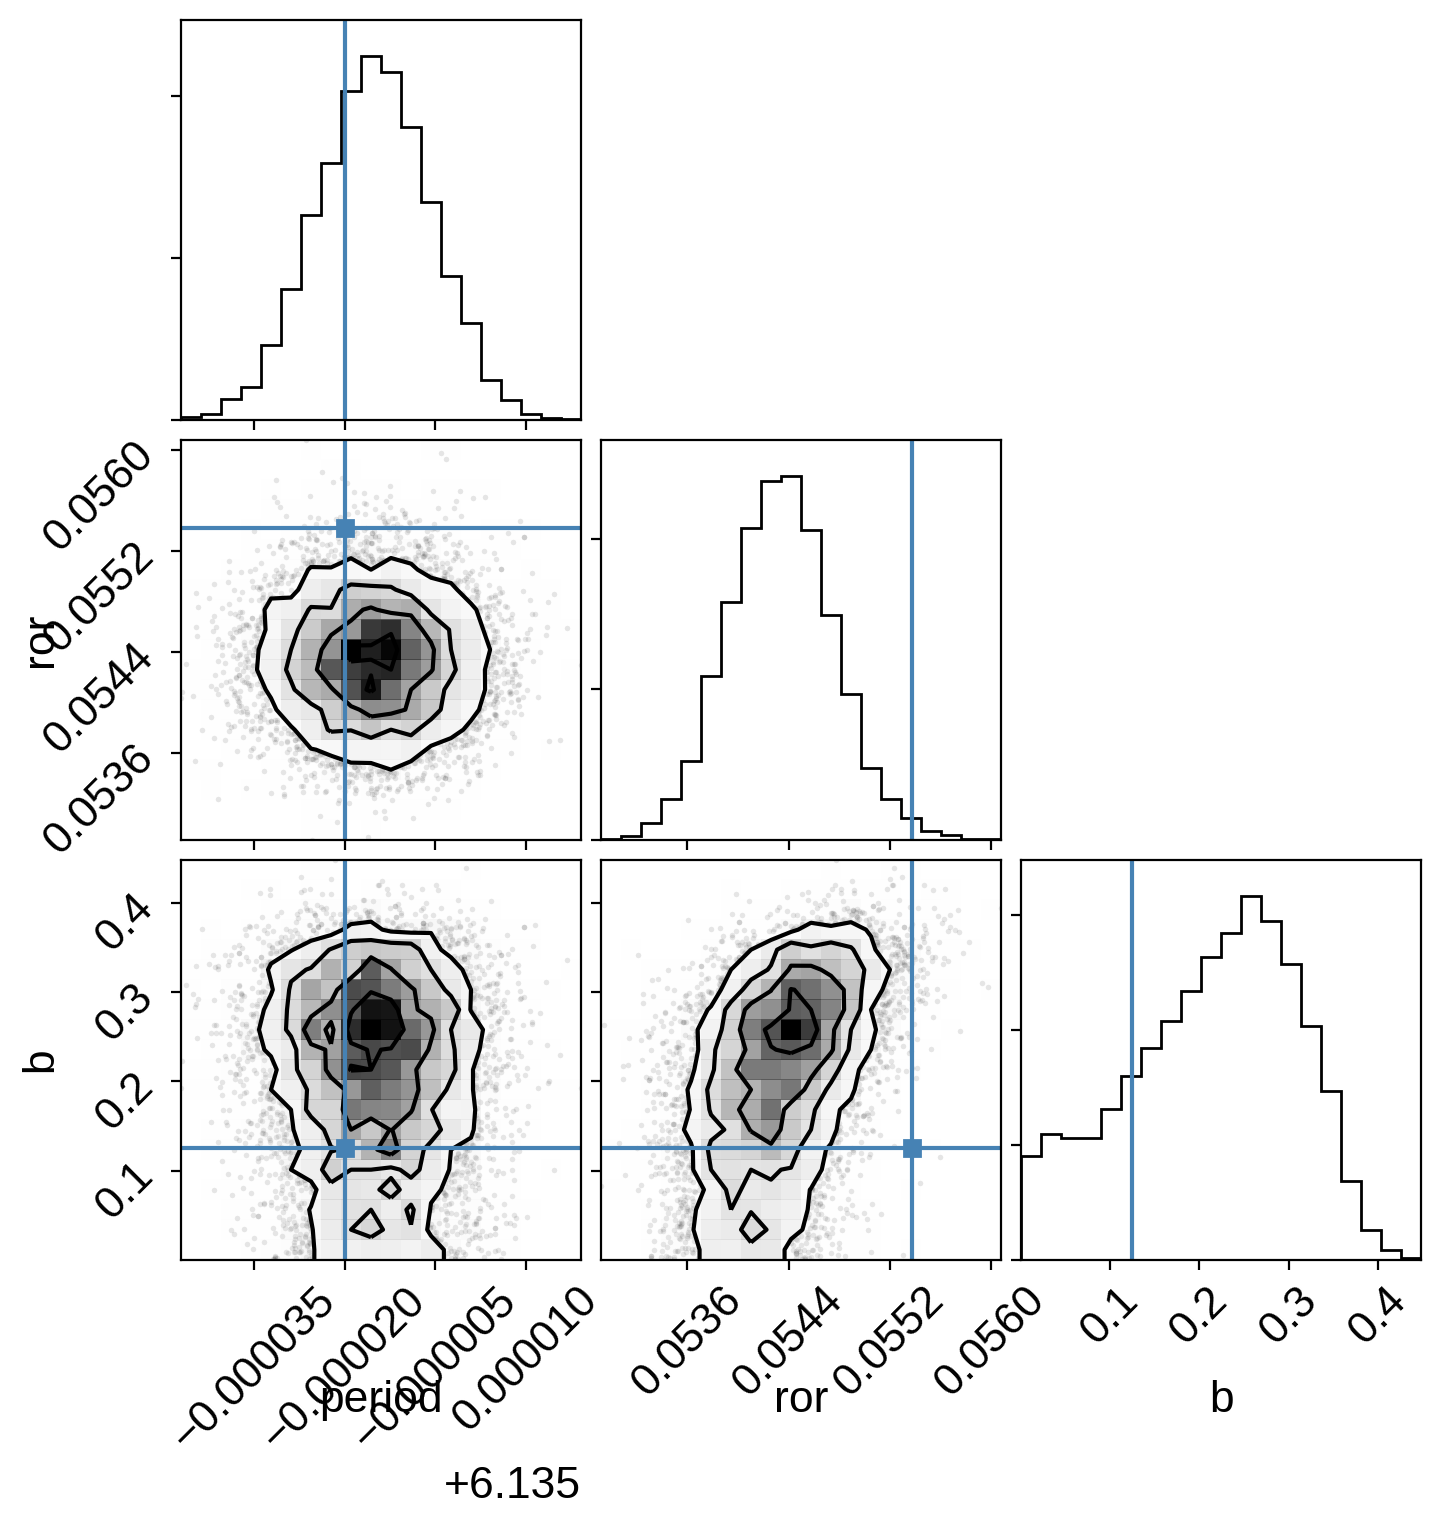

In [10]:
import corner
import astropy.units as u

samples = pm.trace_to_dataframe(trace, varnames=["period", "ror", "b"])
corner.corner(samples, truths=[6.134980, 0.05538, 0.125]);

## Bonus: eccentricity

As discussed above, we fit this model assuming a circular orbit which speeds things up for a few reasons.
First, setting eccentricity to zero means that the orbital dynamics are much simpler and more computationally efficient, since we don't need to solve Kepler's equation numerically.
But this isn't actually the main effect!
Instead the bigger issues come from the fact that the degeneracies between eccentricity, arrgument of periasteron, impact parameter, and planet radius are hard for the sampler to handle, causing the sampler's performance to plummet.
In this case, by fitting with a circular orbit where duration is one of the parameters, everything is well behaved and the sampler runs faster.

But, in this case, the planet *is* actually on an eccentric orbit, so that assumption isn't justified.
It has been recognized by various researchers over the years (I first learned about this from [Bekki Dawson](https://arxiv.org/abs/1203.5537)) that, to first order, the eccentricity mainly just changes the transit duration.
The key realization is that this can be thought of as a change in the impled density of the star.
Therefore, if you fit the transit using stellar density (or duration, in this case) as one of the parameters (*note: you must have a* different *stellar density parameter for each planet if there are more than one*), you can use an independent measurement of the stellar density to infer the eccentricity of the orbit after the fact.
All the details are described in [Dawson & Johnson (2012)](https://arxiv.org/abs/1203.5537), but here's how you can do this here using the stellar density listed in the TESS input catalog:

rho_star = 0.121689 ± 0.0281776


eccentricity = 0.45 +0.25 -0.14


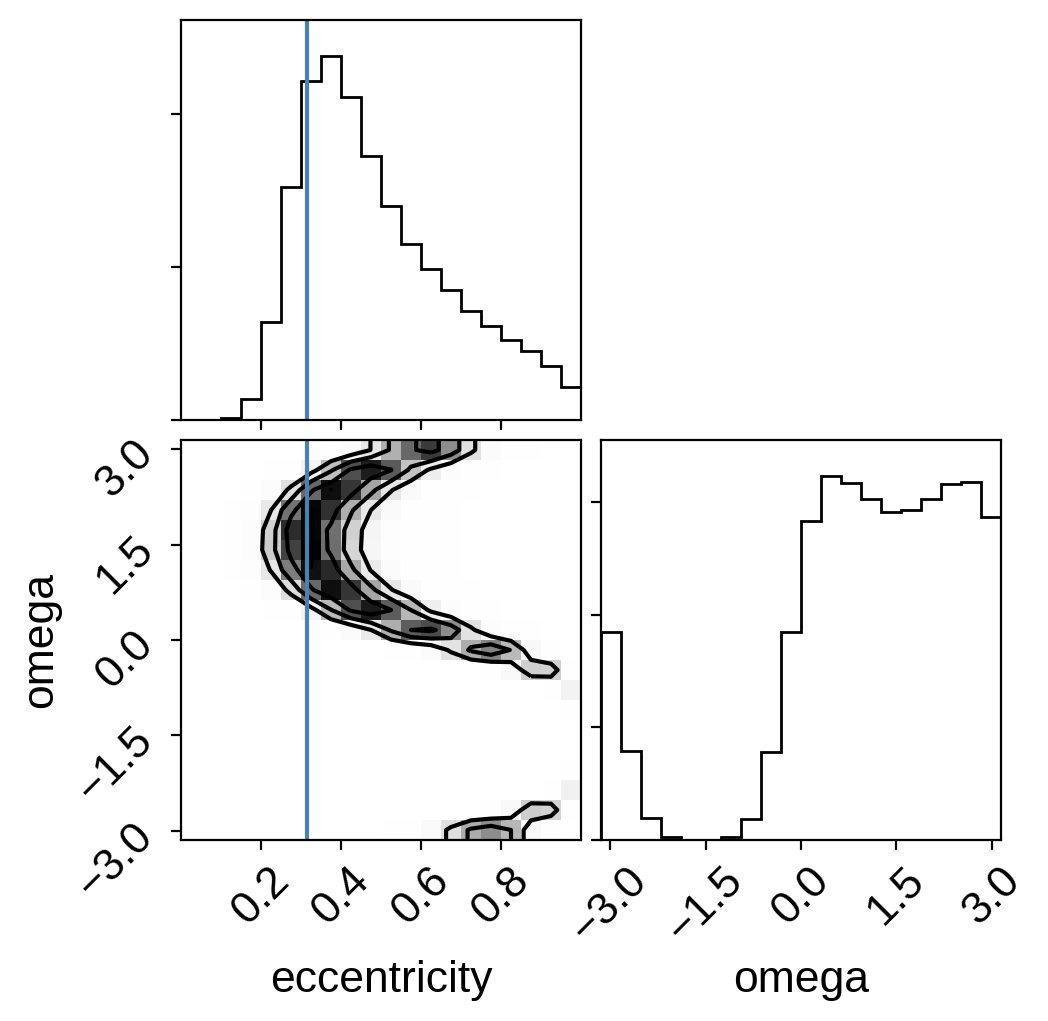

In [11]:
from astroquery.mast import Catalogs

star = Catalogs.query_object("TIC 286923464", catalog="TIC", radius=0.001)
tic_rho_star = float(star["rho"]), float(star["e_rho"])
print("rho_star = {0} ± {1}".format(*tic_rho_star))

# Extract the implied density from the fit
rho_circ = np.repeat(trace["rho_circ"], 100)

# Sample eccentricity and omega from their priors (the math might
# be a little more subtle for more informative priors, but I leave
# that as an exercise for the reader...)
ecc = np.random.uniform(0, 1, len(rho_circ))
omega = np.random.uniform(-np.pi, np.pi, len(rho_circ))

# Compute the "g" parameter from Dawson & Johnson and what true
# density that implies
g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc ** 2)
rho = rho_circ / g ** 3

# Re-weight these samples to get weighted posterior samples
log_weights = -0.5 * ((rho - tic_rho_star[0]) / tic_rho_star[1]) ** 2
weights = np.exp(log_weights - np.max(log_weights))

# Estimate the expected posterior quantiles
q = corner.quantile(ecc, [0.16, 0.5, 0.84], weights=weights)
print("eccentricity = {0:.2f} +{1[1]:.2f} -{1[0]:.2f}".format(q[1], np.diff(q)))

corner.corner(
    np.vstack((ecc, omega)).T,
    weights=weights,
    truths=[0.316, None],
    plot_datapoints=False,
    labels=["eccentricity", "omega"],
);

As you can see, this eccentricity estimate is consistent (albeit with large uncertainties) with the value that [Pepper et al. (2019)](https://arxiv.org/abs/1911.05150) measure using radial velocities and it is definitely clear that this planet is not on a circular orbit.

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [12]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [13]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.0},
   month = apr,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
